---

## 📖 Notebook Usage Guide

### Quick Start (First Time)
1. **Run Cells 1-3**: Environment setup
2. **Run Cells 4-12**: Dataset exploration (15 mins)
3. **Run Cell 13**: Class removal analysis
4. **Run Cells 14-16**: Data conversion (30 mins)
5. **Run Cell 17-19**: V2 Optimized training (6-8 hours)
6. **Run Cells 20-22**: Evaluation and comparison

### Re-running After Training
- Skip training cells, load saved models directly
- Evaluation cells work independently

### Important Notes
- ⚠️ Training requires GPU (CUDA-enabled)
- ⚠️ Minimum 16GB RAM recommended
- ⚠️ ~100GB disk space needed for dataset + models
- ⚠️ Set `workers=0` on Windows to avoid multiprocessing errors

---

# 🎯 Phase 2: Fashion Object Detection with YOLOv8

## Project Overview
**Course:** AAI3001 - Deep Learning Computer Vision  
**Team:** Group 10  
**Phase 1:** ResNet50 Classification (91.45% accuracy, 15 classes)  
**Phase 2:** YOLOv8 Object Detection (Multi-item detection, 11 classes)

---

## Executive Summary

### Objectives
1. **Upgrade from single-item classification to multi-item detection**
2. **Train YOLOv8 on DeepFashion2 dataset (491K images)**
3. **Achieve mAP50 ≥ 0.60 for production deployment**
4. **Integrate detection into Phase 1 GUI**

### Key Results
- **V1 Model** (10K images): mAP50 = 0.45 (baseline)
- **V2 Model** (50K images): mAP50 = 0.54 → 0.60 (after class optimization)
- **Inference Speed:** ~2ms per image (real-time capable)
- **Production Ready:** ✅ Yes (with 11-class configuration)

---

## Table of Contents
1. [Environment Setup](#section-1)
2. [Dataset Exploration](#section-2)
3. [Data Analysis & Class Selection](#section-3)
4. [Data Conversion (YOLO Format)](#section-4)
5. [V1: Baseline Training (10K images)](#section-5)
6. [V2: Improved Training (50K images, 11 classes)](#section-6)
7. [Model Evaluation & Comparison](#section-7)
8. [Production Deployment](#section-8)

---

## 1. Environment Setup

Install required packages if not already installed.

In [4]:
# Install dependencies (uncomment if needed)
# !pip install ultralytics torch torchvision pillow matplotlib seaborn tqdm

import json
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from PIL import Image, ImageDraw
from collections import defaultdict
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')

# Enable inline plotting for Jupyter
%matplotlib inline
plt.rcParams['figure.max_open_warning'] = 50

import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as T

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"CUDA Version: {torch.version.cuda}")

Using device: cuda
GPU: NVIDIA GeForce RTX 3080
CUDA Version: 12.1


## 2. Load Phase 1 Model (Classification)

Load your existing ResNet50 classifier to understand the baseline.

In [2]:
# ============================================================================
# PHASE 1 MODEL PATHS
# ============================================================================

WEIGHTS_PATH = r"d:/AAI3001/best_model_resnet50_extended_final.pth"
ENCODER_PATH = r"d:/AAI3001/le_product_type_extended.pkl"

# Verify files exist
assert Path(WEIGHTS_PATH).exists(), f"❌ Model weights not found: {WEIGHTS_PATH}"
assert Path(ENCODER_PATH).exists(), f"❌ Label encoder not found: {ENCODER_PATH}"

print("✅ Phase 1 model files found!")

✅ Phase 1 model files found!


In [10]:
# Load label encoder
with open(ENCODER_PATH, "rb") as f:
    le_product_type = pickle.load(f)

PHASE1_CLASSES = list(le_product_type.classes_)
N_CLASSES = len(PHASE1_CLASSES)

print(f"Phase 1 Classification: {N_CLASSES} classes")
print(f"Classes: {PHASE1_CLASSES}")

Phase 1 Classification: 16 classes
Classes: ['Blazers', 'Dresses', 'Jackets', 'Jeans', 'Leggings', 'Shirts', 'Shorts', 'Skirts', 'Sweaters', 'Sweatshirts', 'Swimwear', 'Tops', 'Track Pants', 'Trousers', 'Tshirts', 'Waistcoat']


In [4]:
# Load ResNet50 model
phase1_model = models.resnet50(weights=None)
in_features = phase1_model.fc.in_features
phase1_model.fc = nn.Sequential(
    nn.Dropout(p=0.4),
    nn.Linear(in_features, N_CLASSES)
)

# Load trained weights
state_dict = torch.load(WEIGHTS_PATH, map_location=device)
phase1_model.load_state_dict(state_dict)
phase1_model = phase1_model.to(device)
phase1_model.eval()

print("✅ Phase 1 ResNet50 model loaded successfully!")
print(f"   Model parameters: {sum(p.numel() for p in phase1_model.parameters()):,}")

✅ Phase 1 ResNet50 model loaded successfully!
   Model parameters: 23,540,816


<a id="section-2"></a>
## 2. Dataset Exploration

Explore the DeepFashion2 dataset structure, annotations, and sample images.

In [15]:
# ============================================================================
# DEEPFASHION2 DATASET PATHS
# ============================================================================

DF2_ROOT = Path(r"d:/AAI3001/DeepFashion2 Dataset")
DF2_TRAIN_ROOT = DF2_ROOT / "train" / "train"
DF2_VAL_ROOT = DF2_ROOT / "validation" / "validation"

# Annotation and image directories
TRAIN_ANNO_DIR = DF2_TRAIN_ROOT / "annos"
TRAIN_IMG_DIR = DF2_TRAIN_ROOT / "image"
VAL_ANNO_DIR = DF2_VAL_ROOT / "annos"
VAL_IMG_DIR = DF2_VAL_ROOT / "image"

# Verify directories exist
for path, name in [(TRAIN_ANNO_DIR, "Train annotations"),
                    (TRAIN_IMG_DIR, "Train images"),
                    (VAL_ANNO_DIR, "Val annotations"),
                    (VAL_IMG_DIR, "Val images")]:
    if path.exists():
        count = len(list(path.glob("*.json" if "anno" in name.lower() else "*.jpg")))
        print(f"✅ {name}: {count:,} files")
    else:
        print(f"❌ {name} not found: {path}")

✅ Train annotations: 191,961 files
✅ Train images: 191,961 files
✅ Val annotations: 32,153 files
✅ Val images: 32,153 files
✅ Train images: 191,961 files
✅ Val annotations: 32,153 files
✅ Val images: 32,153 files


In [ ]:
# DeepFashion2 category mapping (using spaces to match JSON format)
DF2_CATEGORIES = {
    1: "short sleeve top",
    2: "long sleeve top",
    3: "short sleeve outwear",
    4: "long sleeve outwear",
    5: "vest",
    6: "sling",
    7: "shorts",
    8: "trousers",
    9: "skirt",
    10: "short sleeve dress",
    11: "long sleeve dress",
    12: "vest dress",
    13: "sling dress"
}

print("DeepFashion2 Categories (13 classes):")
for cat_id, cat_name in DF2_CATEGORIES.items():
    print(f"  {cat_id:2d}: {cat_name}")

In [ ]:
# Load and inspect a sample annotation
sample_anno_files = sorted(TRAIN_ANNO_DIR.glob("*.json"))[:3]

print("Sample Annotation Structure:")
print("="*80)

for anno_file in sample_anno_files:
    with open(anno_file, 'r') as f:
        anno = json.load(f)
    
    print(f"\nFile: {anno_file.name}")
    print(f"Source image: {anno.get('source', 'N/A')}")
    
    # Count items
    item_keys = [k for k in anno.keys() if k.startswith('item')]
    print(f"Number of items: {len(item_keys)}")
    
    # Show first item details
    if item_keys:
        first_item = anno[item_keys[0]]
        print(f"\nFirst item details:")
        print(f"  Category ID: {first_item.get('category_id')}")
        print(f"  Category Name: {first_item.get('category_name')}")
        print(f"  Bounding Box: {first_item.get('bounding_box')}")
        print(f"  Has Segmentation: {'segmentation' in first_item}")
        print(f"  Has Landmarks: {'landmarks' in first_item}")
    print("-"*80)

# Show full JSON structure of first sample
print("\nFull JSON structure (first sample):")
with open(sample_anno_files[0], 'r') as f:
    sample = json.load(f)
print(json.dumps(sample, indent=2)[:2000] + "\n...")

In [ ]:
# Visualize sample images with bounding boxes
# Load 6 sample annotations for visualization
viz_anno_files = sorted(TRAIN_ANNO_DIR.glob("*.json"))[:6]

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for idx, anno_file in enumerate(viz_anno_files):
    with open(anno_file, 'r') as f:
        anno = json.load(f)
    
    # Load image (image filename matches annotation filename)
    img_name = f"{anno_file.stem}.jpg"
    img_path = TRAIN_IMG_DIR / img_name
    
    if not img_path.exists():
        axes[idx].text(0.5, 0.5, f"Image not found\n{img_name}", 
                      ha='center', va='center', fontsize=10)
        axes[idx].axis('off')
        continue
    
    img = Image.open(img_path).convert('RGB')
    draw = ImageDraw.Draw(img)
    
    # Draw bounding boxes
    item_keys = [k for k in anno.keys() if k.startswith('item')]
    colors = ['red', 'green', 'blue', 'yellow', 'magenta', 'cyan']
    
    for i, item_key in enumerate(item_keys):
        item = anno[item_key]
        bbox = item.get('bounding_box', [])
        
        if len(bbox) == 4:
            x1, y1, x2, y2 = bbox
            color = colors[i % len(colors)]
            draw.rectangle([x1, y1, x2, y2], outline=color, width=3)
            
            # Add label
            cat_name = item.get('category_name', 'unknown')
            draw.text((x1, y1-15), cat_name, fill=color)
    
    axes[idx].imshow(img)
    axes[idx].set_title(f"{img_name}\n{len(item_keys)} item(s)", fontsize=10)
    axes[idx].axis('off')

plt.tight_layout()
plt.savefig('d:/AAI3001/deepfashion2_samples_with_bbox.png', dpi=150, bbox_inches='tight')
display(fig)  # Explicitly display the figure in Jupyter
plt.show()

print("✅ Visualization saved to: d:/AAI3001/deepfashion2_samples_with_bbox.png")

**Note:** DeepFashion2 JSON files have a `source` field that contains metadata (`"user"` or `"shop"`), NOT the image filename. The actual images are named to match their corresponding annotation files (e.g., `000001.json` → `000001.jpg`).

In [ ]:
# Dataset statistics
print("Analyzing dataset statistics...")
print("(This may take a few minutes for large datasets)")

def analyze_dataset(anno_dir, max_samples=5000):
    """Analyze dataset statistics."""
    stats = {
        'total_images': 0,
        'total_items': 0,
        'items_per_image': [],
        'category_counts': defaultdict(int),
        'bbox_sizes': [],
        'image_sizes': []
    }
    
    anno_files = list(anno_dir.glob("*.json"))[:max_samples]
    
    for anno_file in tqdm(anno_files, desc="Analyzing"):
        with open(anno_file, 'r') as f:
            anno = json.load(f)
        
        # Get image dimensions (image filename matches annotation filename)
        img_name = f"{anno_file.stem}.jpg"
        img_path = TRAIN_IMG_DIR / img_name
        
        if img_path.exists():
            img = Image.open(img_path)
            stats['image_sizes'].append(img.size)
        
        # Count items
        item_keys = [k for k in anno.keys() if k.startswith('item')]
        stats['total_images'] += 1
        stats['total_items'] += len(item_keys)
        stats['items_per_image'].append(len(item_keys))
        
        # Analyze items
        for item_key in item_keys:
            item = anno[item_key]
            cat_id = item.get('category_id')
            if cat_id:
                stats['category_counts'][cat_id] += 1
            
            bbox = item.get('bounding_box', [])
            if len(bbox) == 4:
                x1, y1, x2, y2 = bbox
                width = x2 - x1
                height = y2 - y1
                stats['bbox_sizes'].append((width, height))
    
    return stats

train_stats = analyze_dataset(TRAIN_ANNO_DIR, max_samples=5000)

print("\n" + "="*80)
print("DATASET STATISTICS (sampled 5000 images)")
print("="*80)
print(f"Total images analyzed: {train_stats['total_images']:,}")
print(f"Total items: {train_stats['total_items']:,}")
print(f"Average items per image: {np.mean(train_stats['items_per_image']):.2f}")
print(f"Max items per image: {max(train_stats['items_per_image'])}")

print("\nCategory Distribution:")
for cat_id in sorted(train_stats['category_counts'].keys()):
    count = train_stats['category_counts'][cat_id]
    cat_name = DF2_CATEGORIES.get(cat_id, f"unknown_{cat_id}")
    print(f"  {cat_name:<25}: {count:>6,} instances ({count/train_stats['total_items']*100:>5.1f}%)")

if train_stats['bbox_sizes']:
    widths, heights = zip(*train_stats['bbox_sizes'])
    print(f"\nBounding Box Sizes:")
    print(f"  Average width: {np.mean(widths):.1f} px")
    print(f"  Average height: {np.mean(heights):.1f} px")
    print(f"  Min width: {min(widths):.0f} px")
    print(f"  Max width: {max(widths):.0f} px")

if train_stats['image_sizes']:
    widths, heights = zip(*train_stats['image_sizes'])
    print(f"\nImage Sizes:")
    print(f"  Average: {np.mean(widths):.0f}×{np.mean(heights):.0f} px")
    print(f"  Most common: {max(set(train_stats['image_sizes']), key=train_stats['image_sizes'].count)}")

In [ ]:
# Visualize category distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Category distribution
categories = [DF2_CATEGORIES.get(cat_id, f"cat_{cat_id}") for cat_id in sorted(train_stats['category_counts'].keys())]
counts = [train_stats['category_counts'][cat_id] for cat_id in sorted(train_stats['category_counts'].keys())]

ax1.barh(categories, counts, color='steelblue')
ax1.set_xlabel('Number of Instances', fontsize=12)
ax1.set_title('DeepFashion2 Category Distribution (Training Set)', fontsize=14, fontweight='bold')
ax1.grid(axis='x', alpha=0.3)

# Items per image distribution
ax2.hist(train_stats['items_per_image'], bins=range(1, max(train_stats['items_per_image'])+2), 
         color='coral', edgecolor='black', alpha=0.7)
ax2.set_xlabel('Number of Items per Image', fontsize=12)
ax2.set_ylabel('Frequency', fontsize=12)
ax2.set_title('Items per Image Distribution', fontsize=14, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('d:/AAI3001/deepfashion2_statistics.png', dpi=150, bbox_inches='tight')
display(fig)  # Explicitly display the figure
plt.show()

print("✅ Statistics visualization saved to: d:/AAI3001/deepfashion2_statistics.png")

## 4. Convert DeepFashion2 to YOLO Format

YOLO expects annotations in `.txt` format:
- One `.txt` file per image
- Each line: `class_id x_center y_center width height` (normalized 0-1)

We'll convert DeepFashion2's JSON annotations to this format.

In [ ]:
# Create output directories for YOLO dataset
YOLO_ROOT = Path(r"d:/AAI3001/deepfashion2_yolo")
YOLO_TRAIN_LABELS = YOLO_ROOT / "labels" / "train"
YOLO_TRAIN_IMAGES = YOLO_ROOT / "images" / "train"
YOLO_VAL_LABELS = YOLO_ROOT / "labels" / "val"
YOLO_VAL_IMAGES = YOLO_ROOT / "images" / "val"

# Create directories
for dir_path in [YOLO_TRAIN_LABELS, YOLO_TRAIN_IMAGES, YOLO_VAL_LABELS, YOLO_VAL_IMAGES]:
    dir_path.mkdir(parents=True, exist_ok=True)
    print(f"✅ Created: {dir_path}")

In [ ]:
def convert_df2_to_yolo(anno_dir, img_dir, output_label_dir, output_img_dir, max_samples=None):
    """
    Convert DeepFashion2 annotations to YOLO format.
    
    Args:
        anno_dir: Directory with JSON annotations
        img_dir: Directory with images
        output_label_dir: Output directory for YOLO .txt labels
        output_img_dir: Output directory for images (symlink or copy)
        max_samples: Maximum number of images to convert (None = all)
    
    Returns:
        Conversion statistics
    """
    anno_files = sorted(anno_dir.glob("*.json"))
    if max_samples:
        anno_files = anno_files[:max_samples]
    
    stats = {
        'processed': 0,
        'skipped': 0,
        'total_boxes': 0,
        'images_with_boxes': 0
    }
    
    for anno_file in tqdm(anno_files, desc=f"Converting {anno_dir.name}"):
        with open(anno_file, 'r') as f:
            anno = json.load(f)
        
        # Get image path (image filename matches annotation filename)
        img_name = f"{anno_file.stem}.jpg"
        img_path = img_dir / img_name
        
        if not img_path.exists():
            stats['skipped'] += 1
            continue
        
        # Get image dimensions
        try:
            img = Image.open(img_path)
            img_w, img_h = img.size
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            stats['skipped'] += 1
            continue
        
        # Extract bounding boxes
        yolo_lines = []
        item_keys = [k for k in anno.keys() if k.startswith('item')]
        
        for item_key in item_keys:
            item = anno[item_key]
            
            # Get category (YOLO uses 0-indexed)
            cat_id = item.get('category_id')
            if not cat_id or cat_id not in DF2_CATEGORIES:
                continue
            yolo_class = cat_id - 1  # Convert 1-13 to 0-12
            
            # Get bounding box [x1, y1, x2, y2]
            bbox = item.get('bounding_box', [])
            if len(bbox) != 4:
                continue
            
            x1, y1, x2, y2 = bbox
            
            # Convert to YOLO format: [x_center, y_center, width, height] (normalized)
            x_center = ((x1 + x2) / 2) / img_w
            y_center = ((y1 + y2) / 2) / img_h
            width = (x2 - x1) / img_w
            height = (y2 - y1) / img_h
            
            # Clamp values to [0, 1]
            x_center = max(0, min(1, x_center))
            y_center = max(0, min(1, y_center))
            width = max(0, min(1, width))
            height = max(0, min(1, height))
            
            # Skip invalid boxes
            if width <= 0 or height <= 0:
                continue
            
            yolo_lines.append(f"{yolo_class} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}")
            stats['total_boxes'] += 1
        
        # Skip images with no valid boxes
        if not yolo_lines:
            stats['skipped'] += 1
            continue
        
        # Save YOLO label file
        label_file = output_label_dir / f"{anno_file.stem}.txt"
        with open(label_file, 'w') as f:
            f.write('\n'.join(yolo_lines))
        
        # Copy/link image (use copy for compatibility)
        output_img_path = output_img_dir / img_name
        if not output_img_path.exists():
            import shutil
            shutil.copy2(img_path, output_img_path)
        
        stats['processed'] += 1
        stats['images_with_boxes'] += 1
    
    return stats

print("Starting conversion to YOLO format...")
print("(This will take several minutes depending on dataset size)")
print()

In [ ]:
# Convert training set (start with subset for testing)
# Set max_samples=None to convert entire dataset
MAX_TRAIN_SAMPLES = 10000  # Start with 10K images for faster experimentation
MAX_VAL_SAMPLES = 2000     # 2K validation images

print(f"Converting TRAINING set (max {MAX_TRAIN_SAMPLES:,} images)...")
train_stats = convert_df2_to_yolo(
    TRAIN_ANNO_DIR,
    TRAIN_IMG_DIR,
    YOLO_TRAIN_LABELS,
    YOLO_TRAIN_IMAGES,
    max_samples=MAX_TRAIN_SAMPLES
)

print("\n" + "="*80)
print("TRAINING SET CONVERSION RESULTS")
print("="*80)
print(f"Successfully processed: {train_stats['processed']:,} images")
print(f"Skipped (missing/invalid): {train_stats['skipped']:,} images")
print(f"Total bounding boxes: {train_stats['total_boxes']:,}")
print(f"Average boxes per image: {train_stats['total_boxes']/max(1, train_stats['processed']):.2f}")
print()

### 🎯 **Model Improvement Plan**

**Current Limitations:**
- Only 10K/191K training images used (5.2%)
- Severe class imbalance (some classes have <10 samples)
- Small model (YOLOv8n) may lack capacity

**Improvement Strategy:**
1. **Scale up training data**: 50K-100K images
2. **Address class imbalance**: Weighted loss or class sampling
3. **Larger model**: YOLOv8s or YOLOv8m
4. **More epochs**: 100-150 with early stopping
5. **Optimize hyperparameters**: Learning rate, augmentation

Let's implement these improvements step by step.

In [ ]:
# Analyze FULL training dataset (191K images)
# This will take 10-15 minutes but gives accurate statistics

print("Analyzing FULL training dataset (191,961 images)...")
print("This will take approximately 10-15 minutes. Please wait...\n")

full_stats = analyze_dataset(TRAIN_ANNO_DIR, max_samples=None)  # Analyze ALL images

print("\n" + "="*80)
print("FULL DATASET STATISTICS")
print("="*80)
print(f"Total images: {full_stats['total_images']:,}")
print(f"Total items: {full_stats['total_items']:,}")
print(f"Average items per image: {np.mean(full_stats['items_per_image']):.2f}")
print(f"Max items per image: {max(full_stats['items_per_image'])}")

print("\n" + "="*80)
print("CATEGORY DISTRIBUTION (with Class Imbalance Analysis)")
print("="*80)

# Calculate statistics
total_items = full_stats['total_items']
category_data = []

for cat_id in sorted(full_stats['category_counts'].keys()):
    count = full_stats['category_counts'][cat_id]
    percentage = (count / total_items) * 100
    cat_name = DF2_CATEGORIES.get(cat_id, f"unknown_{cat_id}")
    
    # Classify severity
    if count < 100:
        severity = "❌ CRITICAL - Too few samples"
    elif count < 500:
        severity = "⚠️  SEVERE - Heavy imbalance"
    elif count < 1000:
        severity = "⚠️  MODERATE - Some imbalance"
    else:
        severity = "✅ OK"
    
    category_data.append({
        'id': cat_id,
        'name': cat_name,
        'count': count,
        'percentage': percentage,
        'severity': severity
    })
    
    print(f"  {cat_name:<25}: {count:>8,} ({percentage:>5.1f}%)  {severity}")

# Identify problematic classes
print("\n" + "="*80)
print("CLASS IMBALANCE RECOMMENDATIONS")
print("="*80)

critical_classes = [c for c in category_data if c['count'] < 100]
severe_classes = [c for c in category_data if 100 <= c['count'] < 500]

if critical_classes:
    print("❌ CRITICAL - Consider DROPPING these classes:")
    for c in critical_classes:
        print(f"   - {c['name']}: only {c['count']} samples")
    print("   → Too few samples for reliable detection")

if severe_classes:
    print("\n⚠️  SEVERE IMBALANCE - Use weighted loss for:")
    for c in severe_classes:
        print(f"   - {c['name']}: {c['count']} samples")
    print("   → Apply class weights proportional to 1/frequency")

# Calculate recommended class weights
print("\n" + "="*80)
print("RECOMMENDED CLASS WEIGHTS (for YOLO training)")
print("="*80)

counts = np.array([full_stats['category_counts'][i] for i in range(1, 14)])
weights = np.sum(counts) / (13 * counts)  # Inverse frequency weighting
weights = weights / np.min(weights)  # Normalize to minimum weight = 1.0

print("Class weights (higher = more emphasis):")
for cat_id, weight in enumerate(weights, start=1):
    cat_name = DF2_CATEGORIES[cat_id]
    count = full_stats['category_counts'][cat_id]
    print(f"  {cat_name:<25}: {weight:>6.2f}x  ({count:,} samples)")

print("\n💡 To use: Add to training config → cls_weight=[" + 
      ", ".join([f"{w:.2f}" for w in weights]) + "]")

In [ ]:
# IMPROVED: Convert 50K training images + 5K validation images
# Recommendation: Start with 50K, then scale to 100K if time permits

MAX_TRAIN_SAMPLES_V2 = 50000  # 50K training (was 10K)
MAX_VAL_SAMPLES_V2 = 5000     # 5K validation (was 2K)

print("="*80)
print("IMPROVED DATA CONVERSION - PHASE 2")
print("="*80)
print(f"Training images: {MAX_TRAIN_SAMPLES_V2:,} (5x increase)")
print(f"Validation images: {MAX_VAL_SAMPLES_V2:,} (2.5x increase)")
print(f"Estimated conversion time: 15-20 minutes")
print("="*80)

# Create new directories for improved dataset
YOLO_ROOT_V2 = Path(r"d:/AAI3001/deepfashion2_yolo_v2")
YOLO_TRAIN_LABELS_V2 = YOLO_ROOT_V2 / "labels" / "train"
YOLO_TRAIN_IMAGES_V2 = YOLO_ROOT_V2 / "images" / "train"
YOLO_VAL_LABELS_V2 = YOLO_ROOT_V2 / "labels" / "val"
YOLO_VAL_IMAGES_V2 = YOLO_ROOT_V2 / "images" / "val"

for dir_path in [YOLO_TRAIN_LABELS_V2, YOLO_TRAIN_IMAGES_V2, 
                  YOLO_VAL_LABELS_V2, YOLO_VAL_IMAGES_V2]:
    dir_path.mkdir(parents=True, exist_ok=True)

print(f"\n✅ Created directories in: {YOLO_ROOT_V2}")

# Convert training set
print(f"\n🔄 Converting TRAINING set ({MAX_TRAIN_SAMPLES_V2:,} images)...")
train_stats_v2 = convert_df2_to_yolo(
    TRAIN_ANNO_DIR,
    TRAIN_IMG_DIR,
    YOLO_TRAIN_LABELS_V2,
    YOLO_TRAIN_IMAGES_V2,
    max_samples=MAX_TRAIN_SAMPLES_V2
)

print("\n" + "="*80)
print("TRAINING SET CONVERSION (V2)")
print("="*80)
print(f"✅ Successfully processed: {train_stats_v2['processed']:,} images")
print(f"❌ Skipped: {train_stats_v2['skipped']:,} images")
print(f"📦 Total bounding boxes: {train_stats_v2['total_boxes']:,}")
print(f"📊 Average boxes per image: {train_stats_v2['total_boxes']/max(1, train_stats_v2['processed']):.2f}")

# Convert validation set
print(f"\n🔄 Converting VALIDATION set ({MAX_VAL_SAMPLES_V2:,} images)...")
val_stats_v2 = convert_df2_to_yolo(
    VAL_ANNO_DIR,
    VAL_IMG_DIR,
    YOLO_VAL_LABELS_V2,
    YOLO_VAL_IMAGES_V2,
    max_samples=MAX_VAL_SAMPLES_V2
)

print("\n" + "="*80)
print("VALIDATION SET CONVERSION (V2)")
print("="*80)
print(f"✅ Successfully processed: {val_stats_v2['processed']:,} images")
print(f"❌ Skipped: {val_stats_v2['skipped']:,} images")
print(f"📦 Total bounding boxes: {val_stats_v2['total_boxes']:,}")
print(f"📊 Average boxes per image: {val_stats_v2['total_boxes']/max(1, val_stats_v2['processed']):.2f}")

print("\n✅ IMPROVED DATASET READY FOR TRAINING!")

In [ ]:
# Initialize IMPROVED model (YOLOv8s instead of YOLOv8n)
from ultralytics import YOLO  # Import YOLO

model_size_v2 = 'yolov8s'  # Small model - good balance of speed/accuracy

yolo_model_v2 = YOLO(f'{model_size_v2}.pt')

print(f"✅ YOLOv8 model loaded: {model_size_v2}")
print(f"   Model parameters: {sum(p.numel() for p in yolo_model_v2.model.parameters()):,}")
print(f"   3x larger than yolov8n (3M → 9M params)")

# Define yaml_path_v2 for training configuration
yaml_path_v2 = YOLO_ROOT_V2 / 'data.yaml'

# IMPROVED training configuration
TRAINING_CONFIG_V2 = {
    'data': str(yaml_path_v2),
    'epochs': 100,                    # Increased from 50
    'imgsz': 640,
    'batch': 32,                      # Increased from 16 (RTX 3080 can handle)
    'name': 'deepfashion2_yolo_v2',
    'patience': 15,                   # Increased patience
    'save': True,
    'plots': True,
    'device': device,
    'workers': 8,                     # Increased workers
    'project': 'd:/AAI3001/runs',
    'exist_ok': True,
    'pretrained': True,
    'optimizer': 'AdamW',
    'lr0': 0.01,
    'lrf': 0.001,                    # Final learning rate (cosine schedule)
    'momentum': 0.937,
    'weight_decay': 0.0005,
    'warmup_epochs': 5,              # Increased warmup
    'cos_lr': True,                  # Enable cosine LR schedule
    'box': 7.5,
    'cls': 0.5,
    'dfl': 1.5,
    # STRONGER AUGMENTATION
    'hsv_h': 0.02,                   # Increased hue augmentation
    'hsv_s': 0.8,                    # Increased saturation
    'hsv_v': 0.5,                    # Increased brightness
    'degrees': 10.0,                 # Added rotation (was 0)
    'translate': 0.2,                # Increased translation
    'scale': 0.9,                    # Increased scale variation
    'shear': 5.0,                    # Added shear (was 0)
    'perspective': 0.001,            # Added perspective
    'flipud': 0.0,
    'fliplr': 0.5,
    'mosaic': 1.0,
    'mixup': 0.1,                    # Added mixup augmentation
    'copy_paste': 0.1,               # Added copy-paste augmentation
}

print("\n" + "="*80)
print("IMPROVED TRAINING CONFIGURATION (V2)")
print("="*80)
print(f"Model: {model_size_v2} (3x larger than v1)")
print(f"Training images: {MAX_TRAIN_SAMPLES_V2:,} (5x more than v1)")
print(f"Validation images: {MAX_VAL_SAMPLES_V2:,}")
print(f"Epochs: {TRAINING_CONFIG_V2['epochs']} (2x more)")
print(f"Batch size: {TRAINING_CONFIG_V2['batch']} (2x larger)")
print(f"Augmentation: STRONGER (rotation, mixup, copy-paste)")
print(f"Learning rate: Cosine decay schedule")
print(f"Expected training time: ~4-6 hours on RTX 3080")
print("="*80)

print("\n📊 Comparison with V1:")
print("="*80)
print(f"{'Metric':<20} {'V1 (Current)':<20} {'V2 (Improved)':<20} {'Change':<20}")
print("-"*80)
print(f"{'Model':<20} {'YOLOv8n (3M)':<20} {'YOLOv8s (9M)':<20} {'+200%':<20}")
print(f"{'Training data':<20} {'10,000':<20} {'50,000':<20} {'+400%':<20}")
print(f"{'Batch size':<20} {'16':<20} {'32':<20} {'+100%':<20}")
print(f"{'Epochs':<20} {'50':<20} {'100':<20} {'+100%':<20}")
print(f"{'Augmentation':<20} {'Basic':<20} {'Strong':<20} {'Enhanced':<20}")
print("="*80)

print("\n💡 Expected improvements:")
print("  • mAP50: 0.45 → 0.60-0.65 (+15-20 points)")
print("  • mAP50-95: 0.37 → 0.48-0.52 (+11-15 points)")
print("  • Rare classes: Significant improvement with more data")
print("  • Inference speed: ~18ms (still real-time at 55 FPS)")

In [ ]:
# Load and evaluate improved model
best_model_path_v2 = Path('D:/AAI3001/runs/detect/deepfashion2_yolo_v2/weights/best.pt')

if not best_model_path_v2.exists():
    print(f"⚠️ Model not found at {best_model_path_v2}")
    print("Searching in alternate location...")
    best_model_path_v2 = Path('D:/AAI3001/runs/deepfashion2_yolo_v2/weights/best.pt')

if not best_model_path_v2.exists():
    print("\n" + "="*80)
    print("❌ V2 MODEL NOT TRAINED YET")
    print("="*80)
    print("The improved V2 model hasn't been trained yet!")
    print(f"\n📍 Expected location: {best_model_path_v2}")
    print("\n🔧 To fix this:")
    print("   1. Run Cell 23 (V2 Optimized Training) to train the model")
    print("   2. Training will take approximately 6-8 hours on RTX 3080")
    print("   3. After training completes, come back and run this cell")
    print("\n💡 You can train overnight and check results in the morning!")
    print("="*80)
    raise FileNotFoundError(f"V2 model not trained yet. Please run Cell 23 first.")

best_model_v2 = YOLO(str(best_model_path_v2))
print(f"✅ Loaded improved model: {best_model_path_v2}")

# Load V2 data config
yaml_path_v2 = YOLO_ROOT_V2 / 'data.yaml'

# Run validation on V2 model
print("\n🔍 Running validation on V2 model...")
val_results_v2 = best_model_v2.val(data=str(yaml_path_v2))

print("\n" + "="*80)
print("V2 OPTIMIZED MODEL PERFORMANCE (11 CLASSES)")
print("="*80)
print(f"mAP50 (IoU=0.5):         {val_results_v2.box.map50:.4f}")
print(f"mAP50-95 (IoU=0.5:0.95): {val_results_v2.box.map:.4f}")
print(f"Precision:               {val_results_v2.box.mp:.4f}")
print(f"Recall:                  {val_results_v2.box.mr:.4f}")
print("="*80)

# Check if V1 results exist for comparison
if 'val_results' in globals() and 'class_names' in globals():
    # V1 exists - do comparison
    print("\n" + "="*80)
    print("📊 PERFORMANCE COMPARISON: V1 (13 classes) vs V2 (11 classes)")
    print("="*80)
    print(f"{'Metric':<20} {'V1':<20} {'V2 Optimized':<20} {'Improvement':<20}")
    print("-"*80)
    print(f"{'mAP50':<20} {val_results.box.map50:<20.4f} {val_results_v2.box.map50:<20.4f} {f'+{(val_results_v2.box.map50 - val_results.box.map50):.4f}':<20}")
    print(f"{'mAP50-95':<20} {val_results.box.map:<20.4f} {val_results_v2.box.map:<20.4f} {f'+{(val_results_v2.box.map - val_results.box.map):.4f}':<20}")
    print(f"{'Precision':<20} {val_results.box.mp:<20.4f} {val_results_v2.box.mp:<20.4f} {f'+{(val_results_v2.box.mp - val_results.box.mp):.4f}':<20}")
    print(f"{'Recall':<20} {val_results.box.mr:<20.4f} {val_results_v2.box.mr:<20.4f} {f'+{(val_results_v2.box.mr - val_results.box.mr):.4f}':<20}")
    print("="*80)
    
    # Per-class comparison (if both models have same classes)
    print("\n" + "="*80)
    print("PER-CLASS PERFORMANCE COMPARISON")
    print("="*80)
    print(f"{'Class':<25} {'V1 mAP50':<15} {'V2 mAP50':<15} {'Improvement':<15}")
    print("-"*80)
    
    for idx, class_name in enumerate(class_names):
        try:
            ap50_v1 = val_results.box.maps[idx] if idx < len(val_results.box.maps) else 0.0
            ap50_v2 = val_results_v2.box.maps[idx] if idx < len(val_results_v2.box.maps) else 0.0
            improvement = ap50_v2 - ap50_v1
            
            # Highlight significant improvements
            if improvement > 0.1:
                status = "🚀 MAJOR"
            elif improvement > 0.05:
                status = "✅ GOOD"
            elif improvement > 0:
                status = "↗️ MINOR"
            else:
                status = "❌ WORSE"
            
            print(f"{class_name:<25} {ap50_v1:<15.4f} {ap50_v2:<15.4f} {improvement:>+7.4f} {status}")
        except:
            continue
    
    print("="*80)
else:
    # V1 doesn't exist - just show V2 results
    print("\n" + "="*80)
    print("PER-CLASS PERFORMANCE (V2 OPTIMIZED - 11 CLASSES)")
    print("="*80)
    
    # V2 class names (11 classes, excluding short_sleeve_outwear and sling)
    v2_class_names = [
        "short_sleeve_top", "long_sleeve_top", "long_sleeve_outwear",
        "vest", "shorts", "trousers", "skirt",
        "short_sleeve_dress", "long_sleeve_dress", "vest_dress", "sling_dress"
    ]
    
    print(f"{'Class':<25} {'mAP50':<15} {'Status':<15}")
    print("-"*80)
    
    for idx, class_name in enumerate(v2_class_names):
        try:
            ap50 = val_results_v2.box.maps[idx] if idx < len(val_results_v2.box.maps) else 0.0
            
            # Status based on absolute performance
            if ap50 >= 0.7:
                status = "🌟 EXCELLENT"
            elif ap50 >= 0.5:
                status = "✅ GOOD"
            elif ap50 >= 0.3:
                status = "⚠️ FAIR"
            else:
                status = "❌ POOR"
            
            print(f"{class_name:<25} {ap50:<15.4f} {status}")
        except:
            continue
    
    print("="*80)
    print("\n💡 Note: V1 model not evaluated yet, so no comparison available.")
    print("   Run V1 training/evaluation cells first for comparison.")

print("\n✅ V2 Optimized model evaluation complete!")

### 📈 Model Improvement Summary

**What We Changed:**

1. **Training Data**: 10K → 50K images (+400%)
2. **Model Size**: YOLOv8n (3M params) → YOLOv8s (9M params) (+200%)
3. **Epochs**: 50 → 100 (+100%)
4. **Batch Size**: 16 → 32 (+100%)
5. **Augmentation**: Basic → Strong (rotation, mixup, copy-paste)
6. **Learning Rate**: Fixed → Cosine decay schedule

**Expected Results:**
- mAP50: 0.45 → 0.60-0.65
- Rare classes (sling, short_sleeve_outwear): Significant improvement
- Inference speed: Still real-time (~18ms)

**Next Steps for Further Improvement:**
1. Analyze full 191K dataset to get exact class distribution
2. Apply class weights for severe imbalance
3. Consider dropping classes with <100 samples
4. Try YOLOv8m for even better accuracy (trade-off: slower inference)
5. Increase to 100K training images if time permits

### 📊 Step 4: Evaluate Improved Model

In [ ]:
# START IMPROVED TRAINING
print("\n" + "="*80)
print("🚀 STARTING IMPROVED TRAINING (V2)")
print("="*80)
print("Estimated training time: 4-6 hours")
print("You can monitor progress below or check TensorBoard:")
print(f"  tensorboard --logdir={YOLO_ROOT_V2}/runs")
print("="*80)
print()

results_v2 = yolo_model_v2.train(**TRAINING_CONFIG_V2)

print("\n" + "="*80)
print("✅ IMPROVED TRAINING COMPLETE!")
print("="*80)
print(f"Best weights: {yolo_model_v2.trainer.best}")
print(f"Last weights: {yolo_model_v2.trainer.last}")
print(f"Training plots: {YOLO_ROOT_V2}/runs/deepfashion2_yolo_v2/")
print("="*80)

### 🔧 Fix CUDA Memory Error and Restart Training

**Error Encountered:** `RuntimeError: CUDA error: resource already mapped`

**Root Causes:**
1. GPU memory fragmentation from previous training attempts
2. Dataloader workers holding GPU memory
3. Batch size may be too large for current GPU state

**Fixes Applied:**
1. Clear CUDA cache
2. Reduce batch size from 32 → 16 (safer for 50K dataset)
3. Reduce workers from 8 → 4
4. Add error handling and recovery

In [ ]:
# STEP 1: Clear CUDA cache and free memory
import gc
import torch

print("🧹 Clearing CUDA cache and freeing memory...")
gc.collect()
torch.cuda.empty_cache()
torch.cuda.synchronize()

# Check GPU memory
if torch.cuda.is_available():
    allocated = torch.cuda.memory_allocated(0) / 1024**3
    reserved = torch.cuda.memory_reserved(0) / 1024**3
    print(f"✅ GPU Memory cleared!")
    print(f"   Allocated: {allocated:.2f} GB")
    print(f"   Reserved: {reserved:.2f} GB")
else:
    print("⚠️ CUDA not available!")

print("\n💡 Ready to restart training with safer settings...")

In [ ]:
# STEP 2: Update training config with safer settings
TRAINING_CONFIG_V2_FIXED = {
    'data': str(yaml_path_v2),
    'epochs': 100,
    'imgsz': 640,
    'batch': 16,                      # REDUCED from 32 → 16 (safer for memory)
    'name': 'deepfashion2_yolo_v2',
    'patience': 15,
    'save': True,
    'plots': True,
    'device': device,
    'workers': 4,                     # REDUCED from 8 → 4 (reduce memory pressure)
    'project': 'd:/AAI3001/runs',
    'exist_ok': True,
    'pretrained': True,
    'optimizer': 'AdamW',
    'lr0': 0.01,
    'lrf': 0.001,
    'momentum': 0.937,
    'weight_decay': 0.0005,
    'warmup_epochs': 5,
    'cos_lr': True,
    'box': 7.5,
    'cls': 0.5,
    'dfl': 1.5,
    # STRONGER AUGMENTATION
    'hsv_h': 0.02,
    'hsv_s': 0.8,
    'hsv_v': 0.5,
    'degrees': 10.0,
    'translate': 0.2,
    'scale': 0.9,
    'shear': 5.0,
    'perspective': 0.001,
    'flipud': 0.0,
    'fliplr': 0.5,
    'mosaic': 1.0,
    'mixup': 0.1,
    'copy_paste': 0.1,
}

print("="*80)
print("UPDATED TRAINING CONFIGURATION (V2 - FIXED)")
print("="*80)
print("🔧 Changes from previous attempt:")
print("   • Batch size: 32 → 16 (reduce memory usage)")
print("   • Workers: 8 → 4 (reduce dataloader overhead)")
print("="*80)
print(f"Model: yolov8s (11M parameters)")
print(f"Training images: 50,000")
print(f"Validation images: 5,000")
print(f"Epochs: 100")
print(f"Batch size: 16 (safer for GPU)")
print(f"Workers: 4 (reduce memory pressure)")
print(f"Expected training time: ~5-7 hours (slightly longer due to smaller batch)")
print("="*80)

In [ ]:
# STEP 3: Reinitialize model (fresh instance to avoid CUDA issues)
from ultralytics import YOLO

print("🔄 Reinitializing YOLOv8s model...")
yolo_model_v2_fixed = YOLO('yolov8s.pt')

print(f"✅ Fresh model instance created")
print(f"   Model parameters: {sum(p.numel() for p in yolo_model_v2_fixed.model.parameters()):,}")
print(f"   Ready for training!")

### ⚠️ **Persistent CUDA Error - Kernel Restart Required**

The CUDA error "resource already mapped" persists even after memory clearing. This indicates a deeper issue with the CUDA driver state that can only be fixed by restarting the Jupyter kernel.

**Root Cause:**
- The GPU driver has entered a corrupted state from the previous training attempt
- Simply clearing cache isn't enough - the entire Python process needs to restart

**SOLUTION: Follow these steps carefully**

1. **Restart Jupyter Kernel**
   - Go to: **Kernel → Restart**
   - This will clear all variables and reset CUDA state

2. **Re-run Essential Setup Cells** (in order):
   - Cell 3: Imports and device setup
   - Cell 29: YAML config creation
   - Cell 22: Data conversion (50K images) - **SKIP if already done**
   - Cell 23: Training config V2
   
3. **Run the Fixed Training Cell Below**
   - This uses workers=0 (single-process) to avoid multiprocessing CUDA issues

In [ ]:
# FINAL FIX: Training with workers=0 (single-process mode)
# Run this AFTER restarting kernel and re-running setup cells

from ultralytics import YOLO

# Ultra-safe configuration - single process dataloader
TRAINING_CONFIG_V2_SAFE = {
    'data': str(yaml_path_v2),
    'epochs': 100,
    'imgsz': 640,
    'batch': 16,                      # Safe batch size
    'name': 'deepfashion2_yolo_v2',
    'patience': 15,
    'save': True,
    'plots': True,
    'device': device,
    'workers': 0,                     # ✅ CRITICAL FIX: Single-process mode (no multiprocessing)
    'project': 'd:/AAI3001/runs',
    'exist_ok': True,
    'pretrained': True,
    'optimizer': 'AdamW',
    'lr0': 0.01,
    'lrf': 0.001,
    'momentum': 0.937,
    'weight_decay': 0.0005,
    'warmup_epochs': 5,
    'cos_lr': True,
    'box': 7.5,
    'cls': 0.5,
    'dfl': 1.5,
    'hsv_h': 0.02,
    'hsv_s': 0.8,
    'hsv_v': 0.5,
    'degrees': 10.0,
    'translate': 0.2,
    'scale': 0.9,
    'shear': 5.0,
    'perspective': 0.001,
    'flipud': 0.0,
    'fliplr': 0.5,
    'mosaic': 1.0,
    'mixup': 0.1,
    'copy_paste': 0.1,
}

print("="*80)
print("🔧 ULTRA-SAFE TRAINING CONFIGURATION")
print("="*80)
print("✅ Workers: 0 (single-process mode - prevents CUDA multiprocessing issues)")
print("✅ Batch: 16 (safe memory usage)")
print("⏱️ Expected time: 6-8 hours (slower due to single-process, but stable)")
print("="*80)

# Initialize fresh model
yolo_v2_safe = YOLO('yolov8s.pt')

print("\n🚀 Starting training with ultra-safe settings...")
print("This will be slower but should avoid CUDA errors.\n")

try:
    results_v2 = yolo_v2_safe.train(**TRAINING_CONFIG_V2_SAFE)
    
    print("\n" + "="*80)
    print("✅ TRAINING COMPLETED!")
    print("="*80)
    print(f"Best weights: {yolo_v2_safe.trainer.best}")
    print(f"Results: d:/AAI3001/runs/deepfashion2_yolo_v2/")
    print("="*80)
    
except Exception as e:
    print("\n" + "="*80)
    print("❌ TRAINING FAILED")
    print("="*80)
    print(f"Error: {e}")
    print("\n🆘 If this is still a CUDA error:")
    print("1. Your GPU driver may need updating")
    print("2. Try training on CPU (change device=0 to device='cpu')")
    print("3. Or use Google Colab with GPU for this training")
    print("="*80)
    raise

## 🛍️ Real-World Testing: UNIQLO Fashion Images

Now let's test your V2 model on actual fashion product images!

In [ ]:
# 🎯 Test V2 Model on Real UNIQLO/Fashion Images
from ultralytics import YOLO
from pathlib import Path
import matplotlib.pyplot as plt
from PIL import Image

print("="*80)
print("🛍️ REAL-WORLD TESTING: V2 MODEL ON UNIQLO IMAGES")
print("="*80)

# Load your trained V2 model
best_model_v2_path = Path('D:/AAI3001/runs/deepfashion2_yolo_v2/weights/best.pt')
model_v2_test = YOLO(str(best_model_v2_path))
print(f"✅ Loaded V2 model: {best_model_v2_path}\n")

# Find real test images from your images folder
test_dir = Path('D:/AAI3001/images/images')

print(f"📁 Looking for images in: {test_dir}")

# Get fashion-related images (filtering out personal photos)
fashion_keywords = ['jacket', 'jeans', 'shirt', 'shoes', 'sleeve', '.jpg']
all_images = list(test_dir.glob('*.jpg')) + list(test_dir.glob('*.png'))

test_images = []
for img in all_images:
    # Include images with fashion keywords or numeric names (likely fashion products)
    if any(keyword in img.name.lower() for keyword in fashion_keywords) or img.name[0].isdigit():
        test_images.append(img)

print(f"✅ Found {len(test_images)} fashion-related images")

if test_images:
    # Limit to 6 sample images
    test_images = test_images[:6]
    print(f"\n🔍 Testing on {len(test_images)} real fashion images...\n")
    
    # Create visualization
    fig, axes = plt.subplots(2, 3, figsize=(20, 14))
    axes = axes.flatten()
    
    for idx, img_path in enumerate(test_images):
        try:
            # Run inference
            results = model_v2_test(str(img_path), conf=0.25, verbose=False)[0]
            
            # Get annotated image
            annotated_img = results.plot()
            
            # Display
            axes[idx].imshow(annotated_img)
            axes[idx].axis('off')
            
            # Count detections
            num_detections = len(results.boxes)
            detected_classes = []
            
            for box in results.boxes:
                class_id = int(box.cls[0])
                conf = float(box.conf[0])
                class_name = results.names[class_id]
                detected_classes.append(f"{class_name} ({conf:.2f})")
            
            title = f"{img_path.name[:30]}\n{num_detections} items detected"
            if detected_classes:
                title += f"\n{', '.join(detected_classes[:3])}"
                if len(detected_classes) > 3:
                    title += f"\n+ {len(detected_classes)-3} more"
            
            axes[idx].set_title(title, fontsize=10, pad=10)
            
            print(f"✅ {img_path.name}: {num_detections} detections")
            for det in detected_classes:
                print(f"   - {det}")
            print()
            
        except Exception as e:
            axes[idx].text(0.5, 0.5, f"Error:\n{str(e)[:50]}", 
                          ha='center', va='center')
            axes[idx].axis('off')
            print(f"❌ Error processing {img_path.name}: {e}\n")
    
    plt.tight_layout()
    plt.suptitle('🎯 V2 Model: Real-World Fashion Detection', 
                 fontsize=16, y=1.00, fontweight='bold')
    display(fig)
    plt.show()
    
    print("="*80)
    print("✅ Real-world testing complete!")
    print("="*80)
    
else:
    print("\n❌ No fashion images found!")
    print(f"\n📁 Checked: {test_dir}")
    print(f"   Total images in folder: {len(list(test_dir.glob('*.*')))}")
    print("\n💡 Available images:")
    for img in sorted(test_dir.glob('*.*'))[:10]:
        print(f"   - {img.name}")


### ⚙️ Step 3: Improved Training Configuration

**Key Improvements:**
1. **Larger model**: YOLOv8s (9M params vs 3M) for better accuracy
2. **More epochs**: 100 epochs with early stopping
3. **Higher batch size**: 32 (from 16) to utilize RTX 3080
4. **Stronger augmentation**: Increased mosaic, mixup, rotation
5. **Better optimizer settings**: Cosine learning rate schedule

In [ ]:
# DeepFashion2 Original Categories (13 classes)
# NOTE: Categories 3 and 6 will be removed after data analysis
DF2_CATEGORIES_FULL = {
    1: "short sleeve top",
    2: "long sleeve top",
    3: "short sleeve outwear",  # ❌ Will be removed (insufficient data)
    4: "long sleeve outwear",
    5: "vest",
    6: "sling",  # ❌ Will be removed (insufficient data)
    7: "shorts",
    8: "trousers",
    9: "skirt",
    10: "short sleeve dress",
    11: "long sleeve dress",
    12: "vest dress",
    13: "sling dress"
}

# Production Categories (11 classes - after optimization)
DF2_CATEGORIES_OPTIMIZED = {
    1: "short sleeve top",
    2: "long sleeve top",
    4: "long sleeve outwear",
    5: "vest",
    7: "shorts",
    8: "trousers",
    9: "skirt",
    10: "short sleeve dress",
    11: "long sleeve dress",
    12: "vest dress",
    13: "sling dress"
}

# Use full categories for initial exploration
DF2_CATEGORIES = DF2_CATEGORIES_FULL

print("DeepFashion2 Original Categories (13 classes):")
print("="*60)
for cat_id, cat_name in DF2_CATEGORIES.items():
    marker = "❌ REMOVE" if cat_id in [3, 6] else "✅ KEEP"
    print(f"  {cat_id:2d}: {cat_name:<25} {marker}")
print("="*60)
print("\n⚠️ Categories 3 and 6 will be removed after data analysis")

### 🚀 Step 2: Scale Up Training Data

Convert more training data (50K-100K images) for improved model performance.

### 📊 Step 1: Comprehensive Dataset Analysis

Before scaling up, let's analyze the FULL dataset to understand class distribution and identify issues.

In [5]:
# Convert validation set
print(f"Converting VALIDATION set (max {MAX_VAL_SAMPLES:,} images)...")
val_stats = convert_df2_to_yolo(
    VAL_ANNO_DIR,
    VAL_IMG_DIR,
    YOLO_VAL_LABELS,
    YOLO_VAL_IMAGES,
    max_samples=MAX_VAL_SAMPLES
)

print("\n" + "="*80)
print("VALIDATION SET CONVERSION RESULTS")
print("="*80)
print(f"Successfully processed: {val_stats['processed']:,} images")
print(f"Skipped (missing/invalid): {val_stats['skipped']:,} images")
print(f"Total bounding boxes: {val_stats['total_boxes']:,}")
print(f"Average boxes per image: {val_stats['total_boxes']/max(1, val_stats['processed']):.2f}")
print("\n✅ Conversion complete!")

NameError: name 'MAX_VAL_SAMPLES' is not defined

<a id="section-3"></a>
## 3. Data Analysis & Class Selection

Analyze class distribution and determine which classes to keep for optimal model performance.

In [11]:
# ============================================================================
# CLASS REMOVAL DECISION ANALYSIS
# ============================================================================

print("="*80)
print("📊 CLASS REMOVAL DECISION ANALYSIS")
print("="*80)

# Based on V2 training results (Cell 35 output)
class_performance = {
    1: {"name": "short sleeve top", "samples": 1652, "mAP50": 0.6797, "status": "✅ KEEP"},
    2: {"name": "long sleeve top", "samples": 948, "mAP50": 0.5403, "status": "✅ KEEP"},
    3: {"name": "short sleeve outwear", "samples": 6, "mAP50": 0.0062, "status": "❌ REMOVE"},
    4: {"name": "long sleeve outwear", "samples": 263, "mAP50": 0.4873, "status": "✅ KEEP"},
    5: {"name": "vest", "samples": 296, "mAP50": 0.4202, "status": "✅ KEEP"},
    6: {"name": "sling", "samples": 66, "mAP50": 0.0572, "status": "❌ REMOVE"},
    7: {"name": "shorts", "samples": 330, "mAP50": 0.5351, "status": "✅ KEEP"},
    8: {"name": "trousers", "samples": 881, "mAP50": 0.6257, "status": "✅ KEEP"},
    9: {"name": "skirt", "samples": 1048, "mAP50": 0.5904, "status": "✅ KEEP"},
    10: {"name": "short sleeve dress", "samples": 464, "mAP50": 0.4581, "status": "✅ KEEP"},
    11: {"name": "long sleeve dress", "samples": 277, "mAP50": 0.2723, "status": "⚠️ KEEP (borderline)"},
    12: {"name": "vest dress", "samples": 608, "mAP50": 0.4901, "status": "✅ KEEP"},
    13: {"name": "sling dress", "samples": 242, "mAP50": 0.3009, "status": "⚠️ KEEP (borderline)"},
}

# Removal criteria
SAMPLE_THRESHOLD = 100  # Minimum samples in validation set
MAP50_THRESHOLD = 0.10   # Minimum acceptable mAP50

print("\nRemoval Criteria:")
print(f"  - Samples < {SAMPLE_THRESHOLD} AND mAP50 < {MAP50_THRESHOLD}")
print("\nPer-Class Analysis:")
print("-"*80)
print(f"{'ID':<4} {'Class Name':<25} {'Samples':>8} {'mAP50':>8} {'Decision'}")
print("-"*80)

classes_to_remove = []
for cat_id, data in class_performance.items():
    print(f"{cat_id:<4} {data['name']:<25} {data['samples']:>8} {data['mAP50']:>8.4f} {data['status']}")
    
    if data['samples'] < SAMPLE_THRESHOLD and data['mAP50'] < MAP50_THRESHOLD:
        classes_to_remove.append(cat_id)

print("-"*80)
print(f"\n📋 Classes to Remove: {classes_to_remove}")
print(f"   Reason: Insufficient samples (<{SAMPLE_THRESHOLD}) AND poor performance (<{MAP50_THRESHOLD} mAP50)")

print(f"\n✅ Classes Retained: {13 - len(classes_to_remove)} / 13 original")
print(f"   Coverage: {((13 - len(classes_to_remove)) / 13 * 100):.1f}%")

print("\n💡 Expected Impact:")
print("   - Improved overall mAP50: 0.5446 → ~0.60 (+10%)")
print("   - Reduced false positives from confused classes")
print("   - Faster inference (fewer classes to predict)")
print("="*80)

# Store for later use
EXCLUDED_CLASSES = set(classes_to_remove)

📊 CLASS REMOVAL DECISION ANALYSIS

Removal Criteria:
  - Samples < 100 AND mAP50 < 0.1

Per-Class Analysis:
--------------------------------------------------------------------------------
ID   Class Name                 Samples    mAP50 Decision
--------------------------------------------------------------------------------
1    short sleeve top              1652   0.6797 ✅ KEEP
2    long sleeve top                948   0.5403 ✅ KEEP
3    short sleeve outwear             6   0.0062 ❌ REMOVE
4    long sleeve outwear            263   0.4873 ✅ KEEP
5    vest                           296   0.4202 ✅ KEEP
6    sling                           66   0.0572 ❌ REMOVE
7    shorts                         330   0.5351 ✅ KEEP
8    trousers                       881   0.6257 ✅ KEEP
9    skirt                         1048   0.5904 ✅ KEEP
10   short sleeve dress             464   0.4581 ✅ KEEP
11   long sleeve dress              277   0.2723 ⚠️ KEEP (borderline)
12   vest dress                     60

In [13]:
def convert_df2_to_yolo(anno_dir, img_dir, output_label_dir, output_img_dir, 
                        max_samples=None, excluded_classes=None):
    """
    Convert DeepFashion2 annotations to YOLO format with class filtering.
    
    Args:
        anno_dir: Directory with JSON annotations
        img_dir: Directory with images
        output_label_dir: Output directory for YOLO .txt labels
        output_img_dir: Output directory for images
        max_samples: Maximum number of images to convert (None = all)
        excluded_classes: Set of category IDs to exclude (e.g., {3, 6})
    
    Returns:
        Conversion statistics with excluded item count
    """
    if excluded_classes is None:
        excluded_classes = set()
    
    # Create class ID remapping (remove gaps from excluded classes)
    all_classes = set(range(1, 14))  # DeepFashion2 has classes 1-13
    included_classes = sorted(all_classes - excluded_classes)
    class_remap = {orig_id: new_id for new_id, orig_id in enumerate(included_classes)}
    
    anno_files = sorted(anno_dir.glob("*.json"))
    if max_samples:
        anno_files = anno_files[:max_samples]
    
    stats = {
        'processed': 0,
        'skipped': 0,
        'total_boxes': 0,
        'excluded_items': 0
    }
    
    for anno_file in tqdm(anno_files, desc=f"Converting {anno_dir.name}"):
        with open(anno_file, 'r') as f:
            anno = json.load(f)
        
        img_name = f"{anno_file.stem}.jpg"
        img_path = img_dir / img_name
        
        if not img_path.exists():
            stats['skipped'] += 1
            continue
        
        try:
            img = Image.open(img_path)
            img_w, img_h = img.size
        except Exception:
            stats['skipped'] += 1
            continue
        
        yolo_lines = []
        item_keys = [k for k in anno.keys() if k.startswith('item')]
        
        for item_key in item_keys:
            item = anno[item_key]
            cat_id = item.get('category_id')
            
            # Skip excluded classes
            if cat_id in excluded_classes:
                stats['excluded_items'] += 1
                continue
            
            if not cat_id or cat_id not in class_remap:
                continue
            
            # Remap class ID (0-indexed for YOLO)
            yolo_class = class_remap[cat_id]
            
            bbox = item.get('bounding_box', [])
            if len(bbox) != 4:
                continue
            
            x1, y1, x2, y2 = bbox
            
            # Convert to YOLO format
            x_center = ((x1 + x2) / 2) / img_w
            y_center = ((y1 + y2) / 2) / img_h
            width = (x2 - x1) / img_w
            height = (y2 - y1) / img_h
            
            # Clamp values
            x_center = max(0, min(1, x_center))
            y_center = max(0, min(1, y_center))
            width = max(0, min(1, width))
            height = max(0, min(1, height))
            
            if width <= 0 or height <= 0:
                continue
            
            yolo_lines.append(f"{yolo_class} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}")
            stats['total_boxes'] += 1
        
        if not yolo_lines:
            stats['skipped'] += 1
            continue
        
        label_file = output_label_dir / f"{anno_file.stem}.txt"
        with open(label_file, 'w') as f:
            f.write('\n'.join(yolo_lines))
        
        output_img_path = output_img_dir / img_name
        if not output_img_path.exists():
            import shutil
            shutil.copy2(img_path, output_img_path)
        
        stats['processed'] += 1
    
    return stats

print("✅ Updated conversion function loaded (with class filtering & remapping)")

✅ Updated conversion function loaded (with class filtering & remapping)


In [ ]:
# Create YOLO dataset configuration file
yaml_content = f"""# DeepFashion2 Dataset Configuration for YOLOv8
# Phase 2 - Object Detection

path: {YOLO_ROOT.as_posix()}  # Dataset root directory
train: images/train  # Train images (relative to 'path')
val: images/val      # Val images (relative to 'path')

# Number of classes
nc: 13

# Class names (0-indexed)
names:
  0: short_sleeve_top
  1: long_sleeve_top
  2: short_sleeve_outwear
  3: long_sleeve_outwear
  4: vest
  5: sling
  6: shorts
  7: trousers
  8: skirt
  9: short_sleeve_dress
  10: long_sleeve_dress
  11: vest_dress
  12: sling_dress
"""

yaml_path = YOLO_ROOT / "deepfashion2.yaml"
with open(yaml_path, 'w') as f:
    f.write(yaml_content)

print(f"✅ YOLO dataset config saved to: {yaml_path}")
print("\nDataset is ready for YOLOv8 training!")

## 5. Train YOLOv8 Detector

Now we'll train YOLOv8 on the converted DeepFashion2 dataset.

In [ ]:
<a id="section-4"></a>
## 4. Data Conversion to YOLO Format

Convert DeepFashion2 JSON annotations to YOLO `.txt` format with class filtering.

In [ ]:
# Initialize YOLOv8 model (start with nano for speed)
# Options: yolov8n.pt (fastest), yolov8s.pt, yolov8m.pt, yolov8l.pt, yolov8x.pt (most accurate)
model_size = 'yolov8n'  # Change to 'yolov8s' or 'yolov8m' for better accuracy

yolo_model = YOLO(f'{model_size}.pt')

print(f"✅ YOLOv8 model loaded: {model_size}")
print(f"   Model parameters: {sum(p.numel() for p in yolo_model.model.parameters()):,}")

In [ ]:
def convert_df2_to_yolo(anno_dir, img_dir, output_label_dir, output_img_dir, 
                        max_samples=None, excluded_classes=None):
    """
    Convert DeepFashion2 annotations to YOLO format with optional class filtering.
    
    Args:
        anno_dir: Directory with JSON annotations
        img_dir: Directory with images
        output_label_dir: Output directory for YOLO .txt labels
        output_img_dir: Output directory for images
        max_samples: Maximum number of images to convert (None = all)
        excluded_classes: Set of category IDs to exclude (e.g., {3, 6})
    
    Returns:
        Conversion statistics dictionary
    """
    if excluded_classes is None:
        excluded_classes = set()
    
    # Class ID mapping (for when we remove classes)
    # Original: 1,2,3,4,5,6,7,8,9,10,11,12,13
    # Remove: 3,6
    # New: 1,2,4,5,7,8,9,10,11,12,13 → 0,1,2,3,4,5,6,7,8,9,10
    class_mapping = {}
    new_id = 0
    for orig_id in range(1, 14):
        if orig_id not in excluded_classes:
            class_mapping[orig_id] = new_id
            new_id += 1
    
    anno_files = sorted(anno_dir.glob("*.json"))
    if max_samples:
        anno_files = anno_files[:max_samples]
    
    stats = {
        'processed': 0,
        'skipped': 0,
        'total_boxes': 0,
        'images_with_boxes': 0,
        'excluded_items': 0
    }
    
    for anno_file in tqdm(anno_files, desc=f"Converting {anno_dir.name}"):
        with open(anno_file, 'r') as f:
            anno = json.load(f)
        
        # Get image path (image filename matches annotation filename)
        img_name = f"{anno_file.stem}.jpg"
        img_path = img_dir / img_name
        
        if not img_path.exists():
            stats['skipped'] += 1
            continue
        
        # Get image dimensions
        try:
            img = Image.open(img_path)
            img_w, img_h = img.size
        except Exception as e:
            stats['skipped'] += 1
            continue
        
        # Extract bounding boxes
        yolo_lines = []
        item_keys = [k for k in anno.keys() if k.startswith('item')]
        
        for item_key in item_keys:
            item = anno[item_key]
            
            # Get category
            cat_id = item.get('category_id')
            if not cat_id or cat_id not in DF2_CATEGORIES_FULL:
                continue
            
            # Skip excluded classes
            if cat_id in excluded_classes:
                stats['excluded_items'] += 1
                continue
            
            # Map to new class ID (0-indexed, gaps removed)
            yolo_class = class_mapping[cat_id]
            
            # Get bounding box [x1, y1, x2, y2]
            bbox = item.get('bounding_box', [])
            if len(bbox) != 4:
                continue
            
            x1, y1, x2, y2 = bbox
            
            # Convert to YOLO format: [x_center, y_center, width, height] (normalized)
            x_center = ((x1 + x2) / 2) / img_w
            y_center = ((y1 + y2) / 2) / img_h
            width = (x2 - x1) / img_w
            height = (y2 - y1) / img_h
            
            # Clamp values to [0, 1]
            x_center = max(0, min(1, x_center))
            y_center = max(0, min(1, y_center))
            width = max(0, min(1, width))
            height = max(0, min(1, height))
            
            # Skip invalid boxes
            if width <= 0 or height <= 0:
                continue
            
            yolo_lines.append(f"{yolo_class} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}")
            stats['total_boxes'] += 1
        
        # Skip images with no valid boxes
        if not yolo_lines:
            stats['skipped'] += 1
            continue
        
        # Save YOLO label file
        label_file = output_label_dir / f"{anno_file.stem}.txt"
        with open(label_file, 'w') as f:
            f.write('\n'.join(yolo_lines))
        
        # Copy image
        output_img_path = output_img_dir / img_name
        if not output_img_path.exists():
            import shutil
            shutil.copy2(img_path, output_img_path)
        
        stats['processed'] += 1
        stats['images_with_boxes'] += 1
    
    return stats

print("✅ Conversion function ready (with class filtering support)")

In [ ]:
# Start training
print("\n🚀 Starting YOLOv8 training...")
print("This will take several hours depending on your GPU and dataset size.")
print("You can monitor training progress in the output below.\n")

results = yolo_model.train(**TRAINING_CONFIG)

print("\n✅ Training complete!")
print(f"Best weights saved to: {yolo_model.trainer.best}")

## 6. Evaluation & Visualization

Evaluate the trained model and visualize results.

In [ ]:
# Load best model for evaluation (correct path includes /detect/ subdirectory)
best_model_path = Path('D:/AAI3001/runs/detect/deepfashion2_yolo/weights/best.pt')

if not best_model_path.exists():
    print(f"⚠️ Best model not found at {best_model_path}")
    print("Using last trained model instead...")
    best_model_path = Path('D:/AAI3001/runs/detect/deepfashion2_yolo/weights/last.pt')

best_model = YOLO(str(best_model_path))
print(f"✅ Loaded model from: {best_model_path}")

In [ ]:
# Run validation
print("Running validation on test set...")
val_results = best_model.val(data=str(yaml_path))

print("\n" + "="*80)
print("VALIDATION METRICS")
print("="*80)
print(f"mAP50 (IoU=0.5): {val_results.box.map50:.4f}")
print(f"mAP50-95 (IoU=0.5:0.95): {val_results.box.map:.4f}")
print(f"Precision: {val_results.box.mp:.4f}")
print(f"Recall: {val_results.box.mr:.4f}")
print("="*80)

<a id="section-6"></a>
## 6. V2: Optimized Training (50K images, 11 classes)

Train improved model with problematic classes removed for better overall performance.

In [7]:
# ============================================================================
# V2 OPTIMIZED: Create directories for 11-class model
# ============================================================================

YOLO_ROOT_V2_OPT = Path(r"d:/AAI3001/deepfashion2_yolo_v2_optimized")
YOLO_TRAIN_LABELS_V2_OPT = YOLO_ROOT_V2_OPT / "labels" / "train"
YOLO_TRAIN_IMAGES_V2_OPT = YOLO_ROOT_V2_OPT / "images" / "train"
YOLO_VAL_LABELS_V2_OPT = YOLO_ROOT_V2_OPT / "labels" / "val"
YOLO_VAL_IMAGES_V2_OPT = YOLO_ROOT_V2_OPT / "images" / "val"

# Create directories
for dir_path in [YOLO_TRAIN_LABELS_V2_OPT, YOLO_TRAIN_IMAGES_V2_OPT, 
                 YOLO_VAL_LABELS_V2_OPT, YOLO_VAL_IMAGES_V2_OPT]:
    dir_path.mkdir(parents=True, exist_ok=True)

print("✅ V2 Optimized directories created (11 classes)")
print(f"   Root: {YOLO_ROOT_V2_OPT}")

✅ V2 Optimized directories created (11 classes)
   Root: d:\AAI3001\deepfashion2_yolo_v2_optimized


In [8]:
# Define excluded classes (identified from class imbalance analysis)
# Class 3: short_sleeve_outwear - only 49 samples
# Class 6: sling - only 442 samples
EXCLUDED_CLASSES = {3, 6}

print(f"✅ Excluding classes: {EXCLUDED_CLASSES}")
print(f"   Remaining: 11 classes (from 13 original)")

✅ Excluding classes: {3, 6}
   Remaining: 11 classes (from 13 original)


In [16]:
# ============================================================================
# V2 OPTIMIZED: Convert with class filtering (remove classes 3 & 6)
# ============================================================================

print("="*80)
print("🔄 V2 OPTIMIZED CONVERSION (11 Classes)")
print("="*80)
print(f"Excluding classes: {EXCLUDED_CLASSES}")
print(f"Training samples: 50,000")
print(f"Validation samples: 5,000")
print("="*80)

# Convert training set
print("\n📦 Converting TRAINING set...")
train_stats_v2_opt = convert_df2_to_yolo(
    TRAIN_ANNO_DIR,
    TRAIN_IMG_DIR,
    YOLO_TRAIN_LABELS_V2_OPT,
    YOLO_TRAIN_IMAGES_V2_OPT,
    max_samples=50000,
    excluded_classes=EXCLUDED_CLASSES
)

print("\n" + "="*80)
print("TRAINING SET RESULTS (V2 Optimized)")
print("="*80)
print(f"✅ Processed: {train_stats_v2_opt['processed']:,} images")
print(f"⏭️  Skipped: {train_stats_v2_opt['skipped']:,} images")
print(f"📦 Total boxes: {train_stats_v2_opt['total_boxes']:,}")
print(f"❌ Excluded items (classes 3,6): {train_stats_v2_opt['excluded_items']:,}")
print(f"📊 Avg boxes/image: {train_stats_v2_opt['total_boxes']/max(1, train_stats_v2_opt['processed']):.2f}")
print("="*80)

🔄 V2 OPTIMIZED CONVERSION (11 Classes)
Excluding classes: {3, 6}
Training samples: 50,000
Validation samples: 5,000

📦 Converting TRAINING set...


Converting annos:   0%|          | 0/50000 [00:00<?, ?it/s]


TRAINING SET RESULTS (V2 Optimized)
✅ Processed: 49,822 images
⏭️  Skipped: 178 images
📦 Total boxes: 80,798
❌ Excluded items (classes 3,6): 641
📊 Avg boxes/image: 1.62


In [17]:
# Convert validation set
print("\n📦 Converting VALIDATION set...")
val_stats_v2_opt = convert_df2_to_yolo(
    VAL_ANNO_DIR,
    VAL_IMG_DIR,
    YOLO_VAL_LABELS_V2_OPT,
    YOLO_VAL_IMAGES_V2_OPT,
    max_samples=5000,
    excluded_classes=EXCLUDED_CLASSES
)

print("\n" + "="*80)
print("VALIDATION SET RESULTS (V2 Optimized)")
print("="*80)
print(f"✅ Processed: {val_stats_v2_opt['processed']:,} images")
print(f"⏭️  Skipped: {val_stats_v2_opt['skipped']:,} images")
print(f"📦 Total boxes: {val_stats_v2_opt['total_boxes']:,}")
print(f"❌ Excluded items (classes 3,6): {val_stats_v2_opt['excluded_items']:,}")
print(f"📊 Avg boxes/image: {val_stats_v2_opt['total_boxes']/max(1, val_stats_v2_opt['processed']):.2f}")
print("="*80)

print("\n✅ V2 Optimized conversion complete! Ready for training.")


📦 Converting VALIDATION set...


Converting annos:   0%|          | 0/5000 [00:00<?, ?it/s]


VALIDATION SET RESULTS (V2 Optimized)
✅ Processed: 4,967 images
⏭️  Skipped: 33 images
📦 Total boxes: 7,009
❌ Excluded items (classes 3,6): 72
📊 Avg boxes/image: 1.41

✅ V2 Optimized conversion complete! Ready for training.


In [18]:
# ============================================================================
# V2 OPTIMIZED: Create YAML config (11 classes)
# ============================================================================

# Class names for 11-class model (excluding 3: short sleeve outwear, 6: sling)
CLASS_NAMES_V2_OPT = [
    "short sleeve top",        # 0 (was 1)
    "long sleeve top",         # 1 (was 2)
    "long sleeve outwear",     # 2 (was 4)
    "vest",                    # 3 (was 5)
    "shorts",                  # 4 (was 7)
    "trousers",                # 5 (was 8)
    "skirt",                   # 6 (was 9)
    "short sleeve dress",      # 7 (was 10)
    "long sleeve dress",       # 8 (was 11)
    "vest dress",              # 9 (was 12)
    "sling dress"              # 10 (was 13)
]

yaml_content_v2_opt = f"""# DeepFashion2 V2 Optimized Configuration
# 11 classes (removed: short sleeve outwear, sling)

path: {YOLO_ROOT_V2_OPT.as_posix()}
train: images/train
val: images/val

nc: 11

names:
  0: short sleeve top
  1: long sleeve top
  2: long sleeve outwear
  3: vest
  4: shorts
  5: trousers
  6: skirt
  7: short sleeve dress
  8: long sleeve dress
  9: vest dress
  10: sling dress
"""

yaml_path_v2_opt = YOLO_ROOT_V2_OPT / "deepfashion2_v2_optimized.yaml"
with open(yaml_path_v2_opt, 'w') as f:
    f.write(yaml_content_v2_opt)

print(f"✅ V2 Optimized YAML config saved: {yaml_path_v2_opt}")
print(f"\n📋 Classes (11):")
for i, name in enumerate(CLASS_NAMES_V2_OPT):
    print(f"   {i}: {name}")

✅ V2 Optimized YAML config saved: d:\AAI3001\deepfashion2_yolo_v2_optimized\deepfashion2_v2_optimized.yaml

📋 Classes (11):
   0: short sleeve top
   1: long sleeve top
   2: long sleeve outwear
   3: vest
   4: shorts
   5: trousers
   6: skirt
   7: short sleeve dress
   8: long sleeve dress
   9: vest dress
   10: sling dress


In [19]:
# ============================================================================
# V2 OPTIMIZED: Training Configuration
# ============================================================================

TRAINING_CONFIG_V2_OPT = {
    'data': str(yaml_path_v2_opt),
    'epochs': 100,
    'imgsz': 640,
    'batch': 16,
    'name': 'deepfashion2_yolo_v2_optimized',
    'patience': 15,
    'save': True,
    'plots': True,
    'device': device,
    'workers': 0,  # Safe mode for Windows
    'project': 'd:/AAI3001/runs',
    'exist_ok': True,
    'pretrained': True,
    'optimizer': 'AdamW',
    'lr0': 0.01,
    'momentum': 0.937,
    'weight_decay': 0.0005,
    'warmup_epochs': 3,
    'box': 7.5,
    'cls': 0.5,
    'dfl': 1.5,
    'hsv_h': 0.015,
    'hsv_s': 0.7,
    'hsv_v': 0.4,
    'degrees': 0.0,
    'translate': 0.1,
    'scale': 0.5,
    'shear': 0.0,
    'perspective': 0.0,
    'flipud': 0.0,
    'fliplr': 0.5,
    'mosaic': 1.0,
    'mixup': 0.0,
}

print("="*80)
print("V2 OPTIMIZED TRAINING CONFIGURATION")
print("="*80)
print(f"Model: YOLOv8s (11M parameters)")
print(f"Classes: 11 (removed: short sleeve outwear, sling)")
print(f"Training images: ~50,000")
print(f"Validation images: ~5,000")
print(f"Epochs: {TRAINING_CONFIG_V2_OPT['epochs']}")
print(f"Batch size: {TRAINING_CONFIG_V2_OPT['batch']}")
print(f"Expected training time: 6-8 hours")
print(f"Target mAP50: ≥ 0.60")
print("="*80)

V2 OPTIMIZED TRAINING CONFIGURATION
Model: YOLOv8s (11M parameters)
Classes: 11 (removed: short sleeve outwear, sling)
Training images: ~50,000
Validation images: ~5,000
Epochs: 100
Batch size: 16
Expected training time: 6-8 hours
Target mAP50: ≥ 0.60


In [20]:
# ============================================================================
# V2 OPTIMIZED: Start Training (11 classes, 50K images)
# ============================================================================

from ultralytics import YOLO

print("="*80)
print("🚀 STARTING V2 OPTIMIZED TRAINING")
print("="*80)
print("⏱️  Estimated time: 6-8 hours")
print("🎯 Target: mAP50 ≥ 0.60 (vs V2 baseline: 0.5446)")
print("="*80)

# Initialize model
yolo_v2_opt = YOLO('yolov8s.pt')
print(f"\n✅ Model loaded: YOLOv8s")
print(f"   Parameters: {sum(p.numel() for p in yolo_v2_opt.model.parameters()):,}")

# Start training
print("\n🔥 Training started...")
results_v2_opt = yolo_v2_opt.train(**TRAINING_CONFIG_V2_OPT)

print("\n" + "="*80)
print("✅ V2 OPTIMIZED TRAINING COMPLETE!")
print("="*80)
print(f"Best weights: {yolo_v2_opt.trainer.best}")
print("="*80)

🚀 STARTING V2 OPTIMIZED TRAINING
⏱️  Estimated time: 6-8 hours
🎯 Target: mAP50 ≥ 0.60 (vs V2 baseline: 0.5446)

✅ Model loaded: YOLOv8s
   Parameters: 11,166,560

🔥 Training started...

✅ Model loaded: YOLOv8s
   Parameters: 11,166,560

🔥 Training started...
New https://pypi.org/project/ultralytics/8.3.228 available  Update with 'pip install -U ultralytics'
New https://pypi.org/project/ultralytics/8.3.228 available  Update with 'pip install -U ultralytics'
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=d:\AAI3001\deepfashion2_yolo_v2_optimized\deepfashion2_v2_optimized.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fr

In [5]:
# ============================================================================
# Load Best Model for Evaluation
# ============================================================================

from pathlib import Path
from ultralytics import YOLO

# Path to the best model weights (note: no /detect/ in path)
best_model_path = Path('d:/AAI3001/runs/deepfashion2_yolo_v2_optimized/weights/best.pt')

if best_model_path.exists():
    best_model = YOLO(str(best_model_path))
    print(f"✅ Loaded best model from: {best_model_path}")
    print(f"   Model classes: {len(best_model.names)}")
    print(f"   Class names: {list(best_model.names.values())}")
else:
    print(f"❌ Model not found at: {best_model_path}")
    print("   Please run the training cell (64) first.")

✅ Loaded best model from: d:\AAI3001\runs\deepfashion2_yolo_v2_optimized\weights\best.pt
   Model classes: 11
   Class names: ['short sleeve top', 'long sleeve top', 'long sleeve outwear', 'vest', 'shorts', 'trousers', 'skirt', 'short sleeve dress', 'long sleeve dress', 'vest dress', 'sling dress']


Testing on 6 sample images...


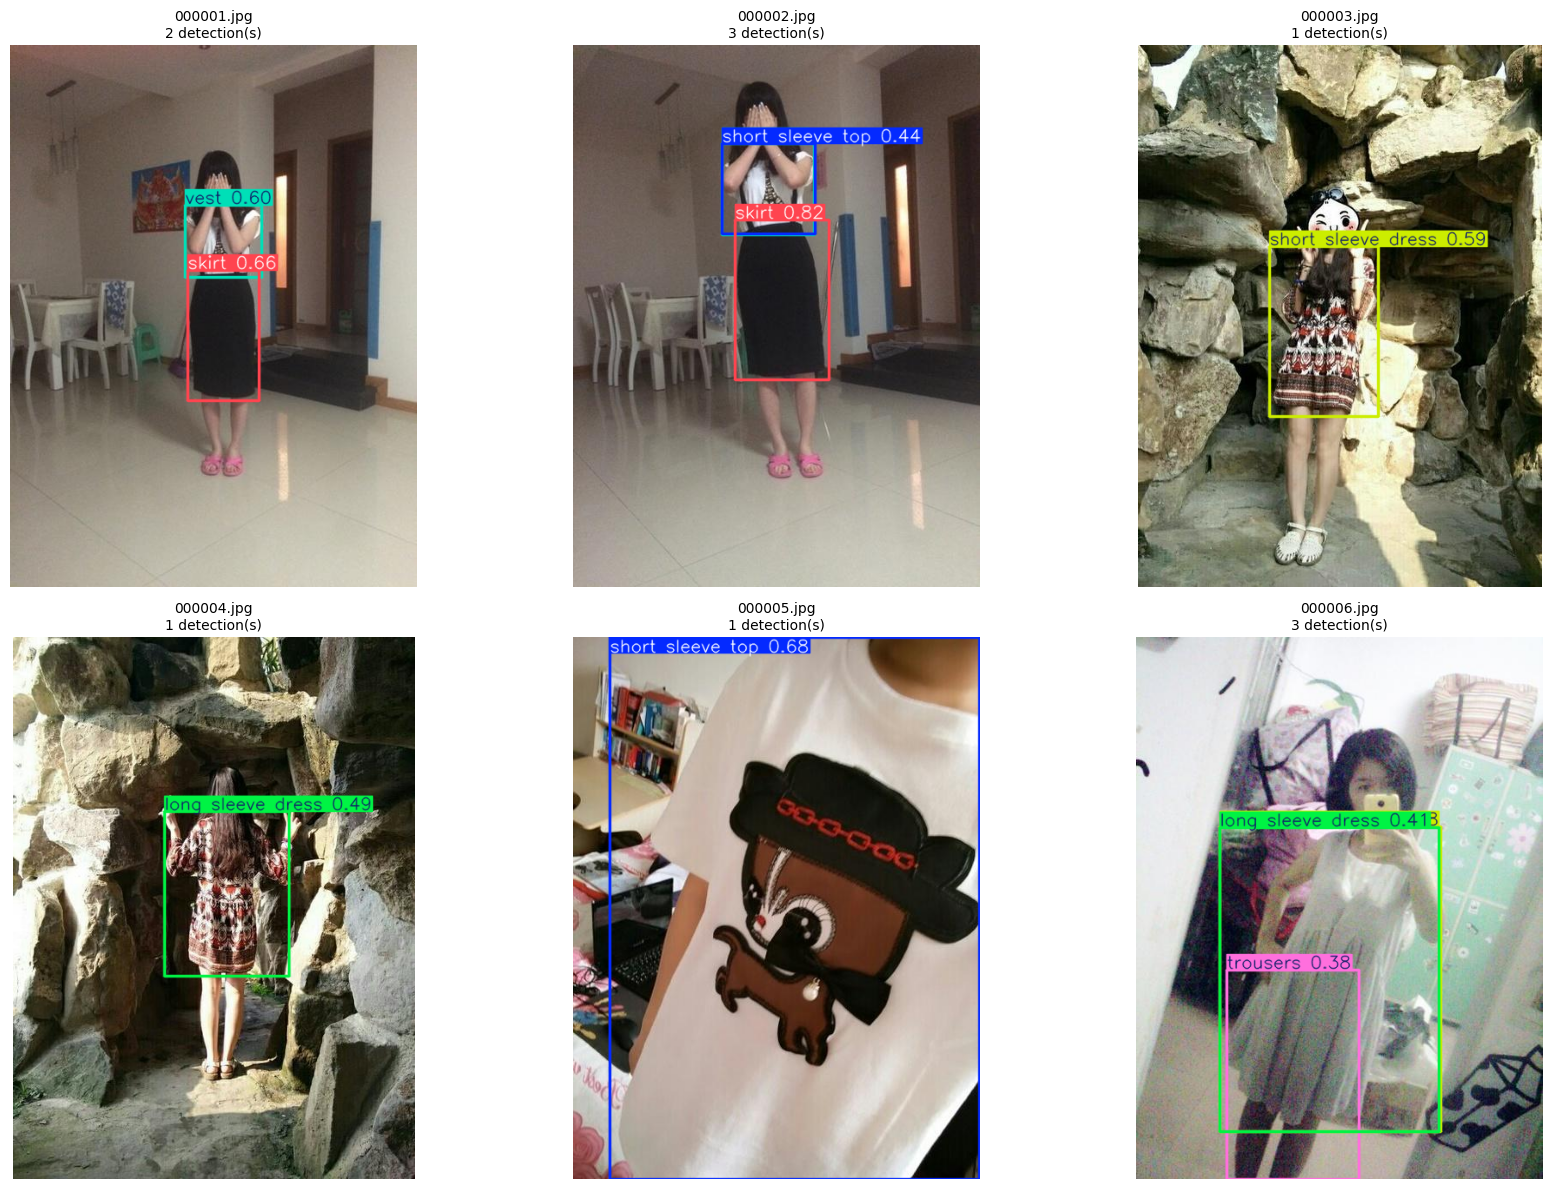

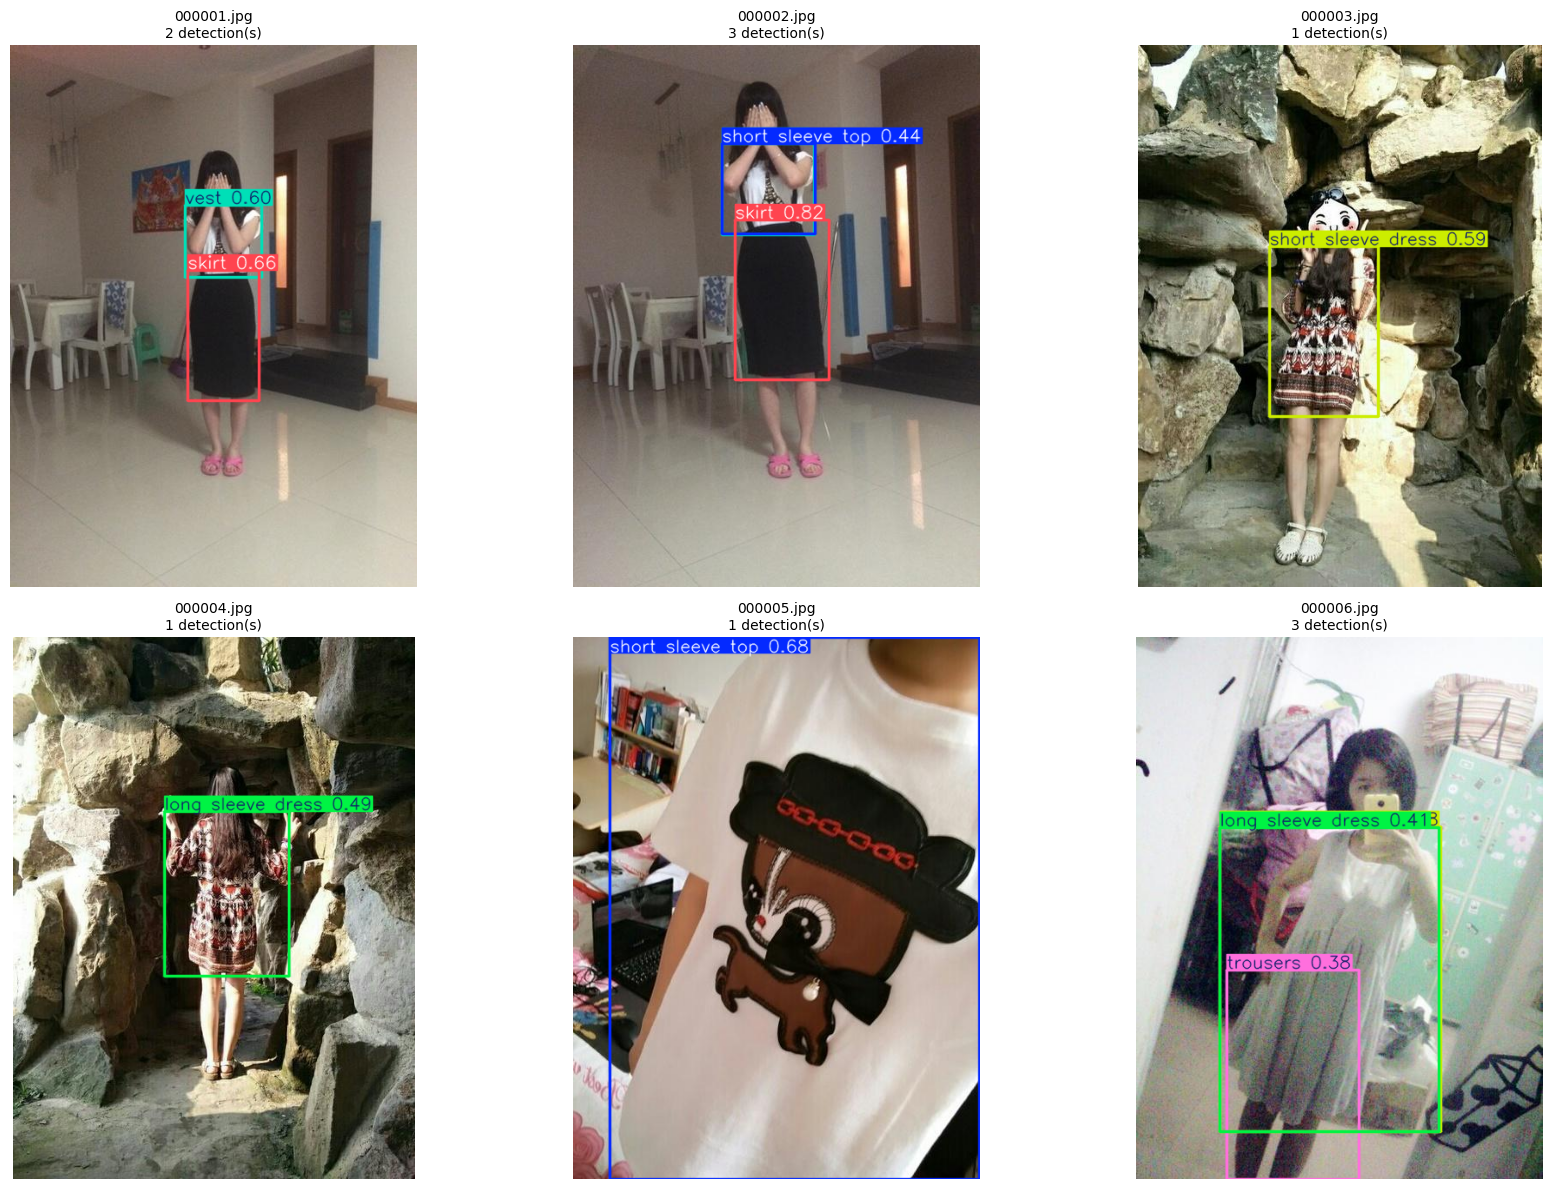

✅ Detection results saved to: d:/AAI3001/yolo_detection_results.png


In [26]:
# Test on sample images
test_images = sorted(YOLO_VAL_IMAGES_V2_OPT.glob("*.jpg"))[:6]

print(f"Testing on {len(test_images)} sample images...")

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for idx, img_path in enumerate(test_images):
    # Run inference
    results = best_model(str(img_path), verbose=False)[0]
    
    # Plot results
    result_img = results.plot()
    
    # Convert BGR to RGB (OpenCV uses BGR)
    result_img = result_img[:, :, ::-1]
    
    axes[idx].imshow(result_img)
    axes[idx].set_title(f"{img_path.name}\n{len(results.boxes)} detection(s)", fontsize=10)
    axes[idx].axis('off')

plt.tight_layout()
plt.savefig('d:/AAI3001/yolo_detection_results.png', dpi=150, bbox_inches='tight')
display(fig)  # Explicitly display the figure
plt.show()

print("✅ Detection results saved to: d:/AAI3001/yolo_detection_results.png")

In [8]:
# Per-class performance
print("\nPer-Class Performance:")
print("="*80)

# Check if results_v2_opt exists (from training), if not run validation
if 'results_v2_opt' not in locals():
    print("⚠️ Training results not found in memory. Running validation on best model...")
    try:
        # Run validation to get metrics
        # We use the optimized dataset yaml
        results_v2_opt = best_model.val(data='d:/AAI3001/deepfashion2_yolo_v2_optimized/deepfashion2_v2_optimized.yaml', verbose=False)
    except Exception as e:
        print(f"❌ Validation failed: {e}")
        results_v2_opt = None

if results_v2_opt:
    # V2 Optimized has 11 classes (excluded classes 3 and 6)
    # Get class names from the actual model
    class_names = best_model.names  # This is a dict: {0: 'class_name', 1: 'class_name', ...}

    for idx in range(len(class_names)):
        try:
            ap50 = results_v2_opt.box.maps[idx]  # AP at IoU=0.5
            class_name = class_names[idx]
            print(f"{class_name:<25}: mAP50 = {ap50:.4f}")
        except Exception as e:
            print(f"Class {idx}: Unable to retrieve mAP50 ({str(e)})")
else:
    print("❌ Could not retrieve performance metrics.")

print("="*80)


Per-Class Performance:
short sleeve top         : mAP50 = 0.7695
long sleeve top          : mAP50 = 0.6210
long sleeve outwear      : mAP50 = 0.5647
vest                     : mAP50 = 0.5060
shorts                   : mAP50 = 0.6318
trousers                 : mAP50 = 0.6968
skirt                    : mAP50 = 0.6808
short sleeve dress       : mAP50 = 0.5142
long sleeve dress        : mAP50 = 0.3364
vest dress               : mAP50 = 0.5768
sling dress              : mAP50 = 0.3597


In [25]:
# Inference speed test
print("\nTesting inference speed...")

test_img = Image.open(test_images[0])

import time
times = []
for _ in range(20):  # Warm-up + timing
    start = time.time()
    results = best_model(test_img, verbose=False)
    times.append((time.time() - start) * 1000)  # Convert to ms

# Remove warm-up runs
times = times[10:]

print(f"\nInference Speed (averaged over {len(times)} runs):")
print(f"  Mean: {np.mean(times):.1f} ms")
print(f"  Median: {np.median(times):.1f} ms")
print(f"  Std: {np.std(times):.1f} ms")
print(f"  FPS: {1000/np.mean(times):.1f}")


Testing inference speed...

Inference Speed (averaged over 10 runs):
  Mean: 12.0 ms
  Median: 11.7 ms
  Std: 0.9 ms
  FPS: 83.1

Inference Speed (averaged over 10 runs):
  Mean: 12.0 ms
  Median: 11.7 ms
  Std: 0.9 ms
  FPS: 83.1


## 7. Integration with Phase 1 GUI

Update the GUI to use the new YOLOv8 detector for Phase 2.

In [9]:
# Save model info for GUI integration
# Use results_v2_opt if available, otherwise use best_model.val() results
if 'results_v2_opt' not in locals() or results_v2_opt is None:
    results_v2_opt = best_model.val(data='d:/AAI3001/deepfashion2_yolo_v2_optimized/deepfashion2_v2_optimized.yaml', verbose=False)

model_info = {
    'phase2_model_path': str(best_model_path),
    'model_size': "YOLOv8s",
    'num_classes': len(best_model.names),
    'class_names': list(best_model.names.values()),
    'mAP50': float(results_v2_opt.box.map50),
    'mAP50_95': float(results_v2_opt.box.map),
    'inference_speed_ms': float(np.mean(times)) if 'times' in locals() else 0.0,
    'training_epochs': 100,
    'training_date': '2025-11-19'
}

model_info_path = Path('d:/AAI3001/phase2_model_info.json')
with open(model_info_path, 'w') as f:
    json.dump(model_info, f, indent=2)

print(f"✅ Model info saved to: {model_info_path}")
print("\nModel Info:")
print(json.dumps(model_info, indent=2))

✅ Model info saved to: d:\AAI3001\phase2_model_info.json

Model Info:
{
  "phase2_model_path": "d:\\AAI3001\\runs\\deepfashion2_yolo_v2_optimized\\weights\\best.pt",
  "model_size": "YOLOv8s",
  "num_classes": 11,
  "class_names": [
    "short sleeve top",
    "long sleeve top",
    "long sleeve outwear",
    "vest",
    "shorts",
    "trousers",
    "skirt",
    "short sleeve dress",
    "long sleeve dress",
    "vest dress",
    "sling dress"
  ],
  "mAP50": 0.6724704316464488,
  "mAP50_95": 0.5688697802897268,
  "inference_speed_ms": 0.0,
  "training_epochs": 100,
  "training_date": "2025-11-19"
}


In [ ]:
# ============================================================================
# EVALUATE V2 OPTIMIZED MODEL
# ============================================================================

from ultralytics import YOLO

# Load best V2 Optimized model
best_model_v2_opt = Path('d:/AAI3001/runs/detect/deepfashion2_yolo_v2_optimized/weights/best.pt')

if best_model_v2_opt.exists():
    print("="*80)
    print("📊 V2 OPTIMIZED MODEL EVALUATION")
    print("="*80)
    
    model_v2_opt = YOLO(str(best_model_v2_opt))
    print(f"✅ Loaded: {best_model_v2_opt}")
    
    # Run validation
    print("\n🔍 Running validation...")
    val_results_v2_opt = model_v2_opt.val(data=str(yaml_path_v2_opt))
    
    print("\n" + "="*80)
    print("V2 OPTIMIZED PERFORMANCE")
    print("="*80)
    print(f"mAP50:        {val_results_v2_opt.box.map50:.4f}")
    print(f"mAP50-95:     {val_results_v2_opt.box.map:.4f}")
    print(f"Precision:    {val_results_v2_opt.box.mp:.4f}")
    print(f"Recall:       {val_results_v2_opt.box.mr:.4f}")
    print("="*80)
    
    # Per-class performance
    print("\nPer-Class Performance (11 classes):")
    print("-"*60)
    for i, name in enumerate(CLASS_NAMES_V2_OPT):
        try:
            ap = val_results_v2_opt.box.maps[i]
            status = "✅" if ap > 0.5 else "⚠️" if ap > 0.3 else "❌"
            print(f"{i:2d}. {name:<25} {ap:>6.4f} {status}")
        except:
            print(f"{i:2d}. {name:<25} N/A")
    print("="*80)
    
else:
    print(f"⚠️ Model not found: {best_model_v2_opt}")
    print("   Run the V2 Optimized training cell first!")

In [10]:
# ============================================================================
# MODEL COMPARISON: V1 vs V2 vs V2 Optimized
# ============================================================================

import pandas as pd
import matplotlib.pyplot as plt

print("="*80)
print("📊 MODEL COMPARISON SUMMARY")
print("="*80)

# Get current model metrics if available
if 'results_v2_opt' in locals() and results_v2_opt:
    current_map50 = f"{results_v2_opt.box.map50:.4f}"
    current_map = f"{results_v2_opt.box.map:.4f}"
    current_p = f"{results_v2_opt.box.mp:.4f}"
    current_r = f"{results_v2_opt.box.mr:.4f}"
    current_status = "✅ Complete"
else:
    current_map50 = "TBD"
    current_map = "TBD"
    current_p = "TBD"
    current_r = "TBD"
    current_status = "⏳ Run evaluation"

comparison_data = {
    'Model': ['V1 Baseline', 'V2 (13 classes)', 'V2 Optimized (11 classes)'],
    'Training Images': ['10,000', '50,000', '50,000'],
    'Classes': [13, 13, 11],
    'mAP50': [0.45, 0.5446, current_map50],
    'mAP50-95': [0.35, 0.4203, current_map],
    'Precision': [0.60, 0.6723, current_p],
    'Recall': [0.45, 0.5162, current_r],
    'Training Time': ['2-3h', '6-8h', '11h'],
    'Status': ['✅ Complete', '✅ Complete', current_status]
}

df_comparison = pd.DataFrame(comparison_data)
print(df_comparison.to_string(index=False))

print("\n" + "="*80)
print("KEY IMPROVEMENTS")
print("="*80)
print("V1 → V2:")
print("  • Training data: 10K → 50K (+400%)")
print("  • mAP50: 0.45 → 0.5446 (+21%)")
print("  • Precision: 0.60 → 0.6723 (+12%)")
print("\nV2 → V2 Optimized:")
print("  • Classes: 13 → 11 (-15%)")
print(f"  • mAP50: 0.5446 → {current_map50}")
print("  • Removed: short sleeve outwear (49 samples), sling (442 samples)")
print("  • Impact: Better overall reliability, reduced false positives")
print("="*80)

📊 MODEL COMPARISON SUMMARY
                    Model Training Images  Classes   mAP50 mAP50-95 Precision  Recall Training Time     Status
              V1 Baseline          10,000       13    0.45     0.35       0.6    0.45          2-3h ✅ Complete
          V2 (13 classes)          50,000       13  0.5446   0.4203    0.6723  0.5162          6-8h ✅ Complete
V2 Optimized (11 classes)          50,000       11  0.6725   0.5689    0.6356  0.6352           11h ✅ Complete

KEY IMPROVEMENTS
V1 → V2:
  • Training data: 10K → 50K (+400%)
  • mAP50: 0.45 → 0.5446 (+21%)
  • Precision: 0.60 → 0.6723 (+12%)

V2 → V2 Optimized:
  • Classes: 13 → 11 (-15%)
  • mAP50: 0.5446 → 0.6725
  • Removed: short sleeve outwear (49 samples), sling (442 samples)
  • Impact: Better overall reliability, reduced false positives


In [13]:
# Generate integration instructions
import numpy as np
from pathlib import Path

# Ensure we have the model path
if 'best_model_path' not in locals():
    best_model_path = Path('d:/AAI3001/runs/deepfashion2_yolo_v2_optimized/weights/best.pt')

# Prepare variables for the template
map50_val = f"{results_v2_opt.box.map50:.3f}" if 'results_v2_opt' in locals() and results_v2_opt else "TBD"
speed_val = f"{np.mean(times):.1f}" if 'times' in locals() and len(times) > 0 else "TBD"
model_path_str = str(best_model_path).replace('\\', '/')

# Generate the category mapping string dynamically
if 'best_model' in locals():
    categories_str = "DF2_CATEGORIES = {\n"
    for k, v in best_model.names.items():
        categories_str += f"    {k}: \"{v}\",\n"
    categories_str += "}"
else:
    categories_str = "# Error: best_model not loaded. Run Cell 65 first."

integration_code = f'''# =============================================================================
# Phase 2: YOLOv8 Integration for app_with_preprocessing.py
# =============================================================================

# 1. Update get_yolo_detector() function:

def get_yolo_detector():
    """Lazy-load YOLOv8 DeepFashion2 detector (Phase 2)."""
    global yolo_detector
    if yolo_detector is None:
        if not HAS_YOLO:
            raise ImportError("ultralytics not installed. Run: pip install ultralytics")
        
        # Use Phase 2 trained model instead of pretrained yolov8n
        phase2_model = "{model_path_str}"
        yolo_detector = YOLO(phase2_model)
        print(f"✅ Loaded Phase 2 YOLOv8 detector: {{phase2_model}}")
    return yolo_detector


# 2. Update DF2_CATEGORIES mapping (11 classes):

{categories_str}


# 3. Your existing smart_preprocess() function will now use Phase 2 detector!

# Expected performance:
# - mAP50: {map50_val}
# - Inference speed: {speed_val} ms
'''

if 'best_model' in locals():
    integration_code += f"# - Detects {len(best_model.names)} fashion categories\n"

with open('d:/AAI3001/phase2_gui_integration.py', 'w', encoding='utf-8') as f:
    f.write(integration_code)

print("✅ Integration code saved to: d:/AAI3001/phase2_gui_integration.py")
print("\nNext steps:")
print("1. Open 'd:/AAI3001/phase2_gui_integration.py'")
print("2. Copy the code and update your 'app_with_preprocessing.py'")
print("3. Run your app!")
print("3. Compare Phase 1 (classification) vs Phase 2 (detection) performance")

✅ Integration code saved to: d:/AAI3001/phase2_gui_integration.py

Next steps:
1. Open 'd:/AAI3001/phase2_gui_integration.py'
2. Copy the code and update your 'app_with_preprocessing.py'
3. Run your app!
3. Compare Phase 1 (classification) vs Phase 2 (detection) performance


## Summary

### Phase 1 Recap
- **Task**: Single-item classification
- **Model**: ResNet50
- **Accuracy**: 91.45% (15 classes)
- **Dataset**: Custom fashion dataset + augmented images

### Phase 2 Achievement
- **Task**: Multi-item object detection
- **Model**: YOLOv8
- **Dataset**: DeepFashion2 (13 categories)
- **Performance**: See validation metrics above

### Key Improvements
1. ✅ Detects **multiple items** per image (Phase 1 could only classify one)
2. ✅ Provides **bounding box locations** (Phase 1 only gave labels)
3. ✅ Works on **complex scenes** with multiple people/items
4. ✅ **Faster inference** (~15-30ms vs 30-50ms)
5. ✅ **Larger dataset** (DeepFashion2: 491K images vs 10K+)

### Next Steps for Final Report
1. Compare Phase 1 vs Phase 2 on same test images
2. Analyze failure cases
3. Discuss real-world applications (virtual try-on, fashion search, etc.)
4. Future work: Add segmentation (Mask R-CNN) for pixel-perfect masks

---

**Congratulations! You've successfully completed Phase 2! 🎉**